# Data understanding

Ik heb van 2 eindgebruikers van werkexpert data gekregen, van Hulter en Kuijpers. van Hulter heb ik van 23, 24 en 25 data gekregen en van Kuijpers heb ik van 24, 25 en een klein deel van 26 data gekregen. 

De data die ik heb ontvangen zijn complete exports van de database. dit betekend dat er heel veel data in staat die ik niet nodig ben en goed moet zoeken naar data die van belang is.

Deze database is al heel erg oud deze is rond 2010 voor het eerst aangemaakt. En word tot nu nog steeds uitgebreid. het is hierdoor ook een hele ingewikkelde database. gevraagd naar een technisch ontwerp of iets maar deze hadden ze helaas niet. ik heb toen wel een uitleg gekregen hoe het globaal werkt. daarna ben ik in de data gedoken opzoek naar bruikbare data. Toen ik had gevonden wat nuttig was heb ik weer gevraagd hoe de tabellen aan elkaar gekoppeld zijn. Dit heb ik allemaal in een word document gezet zodat ik er altijd weer naar kan kijken. 

Hieronder stel ik alle database connecties in. Ik heb van Kuijpers de 2026 er uit gelaten. Ik heb deze keuze gemaakt aangezien er hier heel weinig data in zit en bijna alle orders die er in zitten zijn nog niet uitgevoerd, aan deze orders heb ik niks omdat je daar niet de gewerkte uren van hebt omdat die uren nog niet zijn gewerkt

In [1]:
import pandas as pd
import firebirdsql

# Maak connecties naar alle databases
databases = {
    '23_hulter' : "/firebird/data/HULTER_23 - kopie.GDB",
    '24_hulter' : "/firebird/data/HULTER_24 - kopie.GDB",
    '25_hulter' : "/firebird/data/HULTER_25 - kopie.GDB",
    '24_kuijpers': "/firebird/data/HOOFD_24.GDB",
    '25_kuijpers': "/firebird/data/HOOFD_25.GDB"
}

connections = {}
for jaar, db_path in databases.items():
    connections[jaar] = firebirdsql.connect(
        host="mac-mini-van-terra.local",
        port=3050,
        database=db_path,
        user="SYSDBA", 
        password="masterkey", 
        charset="WIN1252"
    )

Hieronder heb ik een functie geschreven om 1 table in te laden uit alle databases, je geeft een table naam op en de functie haalt dan van alle connecties die ik hierboven heb aangemaakt de data op.het voegt 1 kolom toe genaamd con dit is de database naam want het kan zijn dat allebei de bedrijven een order hebben met het zelfde id maar wel een andere order is. de databases draaien lokaal bij de gebruikers waardoor ze volledig langs elkaar leven en dus met die id's geen rekening houden met elkaar.

In [2]:
# Functie om data uit alle databases te combineren
def fetch_combined_data(table_name, columns="*"):
    all_data = []
    
    for jaar, conn in connections.items():
        df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)
        df['con'] = jaar
        all_data.append(df)
        
    
    combined_df = pd.concat(all_data, ignore_index=True)

    combined_df = combined_df.drop_duplicates()
    return combined_df

TB_TIJDSOORT is een table met tijdsoort_ID en een omschrijving. er is ook een kolom TIJDSOORT_FACTURABEL deze kan true en false zijn. Als deze gefactureerd moet worden staat hij op 1 (true). ik vroeg mij af wat de daadwerkelijk gewerkte uren waren van een werknemer. aangezien effectief en bewerking allebei klinkt als werk. dus ga kijken in de tabel TB_URENVERANTWOORDING en dan de tijdsoort omschrijving er aan vast plakken kijken of dat duidelijkheid bied.

In [3]:
df_tijdsoort = fetch_combined_data('TB_TIJDSOORT')
df_tijdsoort.head(10)

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,TIJDSOORT_ID,TIJDSOORT_CODE,TIJDSOORT_OMS,TIJDSOORT_NIETVERWIJDEREN,TIJDSOORT_KLEUR,TIJDSOORT_INPLANNING,TIJDSOORT_MEEINCONTRTIJD,TIJDSOORT_GEBRBIJDAGSTAAT,TIJDSOORT_ONDERBREKING,TIJDSOORT_MUTDATE,TIJDSOORT_FACTURABEL,TIJDSOORT_VERLOF,TIJDSOORT_REISTIJD,TIJDSOORT_KM,TIJDSOORT_KM_VERPLICHT,TIJDSOORT_ARCHIEF,con
0,2,PZE,Pauze,1.0,0.0,0,0,1,1,2023-01-05 13:04:13.546,0.0,0.0,None,None,None,0,23_hulter
1,3,BWK,Bewerking,1.0,0.0,0,0,1,0,2023-02-15 13:34:29.242,1.0,0.0,None,None,None,0,23_hulter
2,4,BWD,Begin werkdag,1.0,0.0,0,0,0,0,2023-03-24 11:46:41.502,0.0,0.0,None,None,None,1,23_hulter
3,5,EWD,Einde werkdag,1.0,0.0,0,0,0,0,2023-03-24 11:46:45.552,0.0,0.0,None,None,None,1,23_hulter
4,6,220,Dokters bezoek,NaN,0.0,0,0,0,0,2023-01-05 13:04:13.546,0.0,0.0,None,None,None,0,23_hulter
5,7,300,Transport,NaN,0.0,0,0,0,0,2023-03-24 12:00:58.576,0.0,0.0,None,None,None,1,23_hulter
6,8,310,Werkvoorbereiding,NaN,0.0,0,1,1,0,2023-02-15 13:34:50.693,0.0,0.0,None,None,None,0,23_hulter
7,9,400,Storing,NaN,0.0,0,1,0,1,2023-01-05 13:04:13.546,0.0,0.0,None,None,None,0,23_hulter
8,107,SCH,School,NaN,0.0,0,0,0,0,2023-09-11 13:15:02.171,NaN,NaN,None,None,None,0,23_hulter
9,1,EFF,Effectief,1.0,0.0,0,1,0,0,2023-01-05 13:04:13.546,0.0,0.0,None,None,None,0,23_hulter


In [4]:
df_tijdsoort = df_tijdsoort[['con', 'TIJDSOORT_ID', 'TIJDSOORT_FACTURABEL', 'TIJDSOORT_OMS', 'TIJDSOORT_ONDERBREKING']]

Zoals hierboven gezegd ga ik kijken naar de TB_URENVERANTWOORDING hierin staan de uren verantwoording van de medewerkers plus de URENVERANTW_TIJDSOORT deze kolom kan ik gebruiken om de omschrijving er aan toe te voegen. 

In [5]:
df_urenverantwoording = fetch_combined_data('TB_URENVERANTWOORDING')
df_urenverantwoording.head()

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,...,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con
0,2102,2023-01-04,NaN,11677.0,1,1.25,None,1004,15783.0,29601.0,...,NaN,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
1,2103,2023-01-09,NaN,10161.0,1,8.00,None,1011,15800.0,29634.0,...,NaN,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
2,2104,2023-01-10,NaN,10161.0,1,8.00,None,1011,15800.0,29635.0,...,0.0,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
3,2105,2023-01-11,NaN,10161.0,1,8.00,None,1011,15800.0,29636.0,...,0.0,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
4,2106,2023-01-12,NaN,10161.0,1,8.00,None,1011,15800.0,29637.0,...,0.0,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter


In [6]:
df_urenverantwoording.info()

<class 'pandas.DataFrame'>
RangeIndex: 100061 entries, 0 to 100060
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URENVERANTW_ID              100061 non-null  int64  
 1   URENVERANTW_DATUM           100061 non-null  object 
 2   URENVERANTW_PROJID          3203 non-null    float64
 3   URENVERANTW_RELATIEID       89749 non-null   float64
 4   URENVERANTW_TIJDSOORT       100061 non-null  int64  
 5   URENVERANTW_AANTAL          100061 non-null  float64
 6   URENVERANTW_MACHID          1 non-null       object 
 7   URENVERANTW_MEDID           100061 non-null  int64  
 8   URENVERANTW_ORDERID         95498 non-null   float64
 9   URENVERANTW_ORDDAID         95498 non-null   float64
 10  URENVERANTW_ORDMEDID        95498 non-null   float64
 11  URENVERANTW_TIJD            100043 non-null  str    
 12  URENVERANTW_ORDRG_ID        95498 non-null   float64
 13  URENVERANTW_GROEPSID     

Ik voeg hier de omschrijving toe aan de urenverantwoording om te kijken hoe die is opgesteld

In [7]:
df_urenverantwoording = df_urenverantwoording.merge(
    df_tijdsoort, left_on=["URENVERANTW_TIJDSOORT", "con"], right_on=["TIJDSOORT_ID", "con"], how="left"
    )

In [8]:
df_urenverantwoording.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,...,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING
0,2102,2023-01-04,NaN,11677.0,1,1.25,None,1004,15783.0,29601.0,...,NaN,NaN,NaN,None,None,23_hulter,1,0.0,Effectief,0
1,2103,2023-01-09,NaN,10161.0,1,8.00,None,1011,15800.0,29634.0,...,NaN,NaN,NaN,None,None,23_hulter,1,0.0,Effectief,0
2,2104,2023-01-10,NaN,10161.0,1,8.00,None,1011,15800.0,29635.0,...,NaN,NaN,NaN,None,None,23_hulter,1,0.0,Effectief,0
3,2105,2023-01-11,NaN,10161.0,1,8.00,None,1011,15800.0,29636.0,...,NaN,NaN,NaN,None,None,23_hulter,1,0.0,Effectief,0
4,2106,2023-01-12,NaN,10161.0,1,8.00,None,1011,15800.0,29637.0,...,NaN,NaN,NaN,None,None,23_hulter,1,0.0,Effectief,0


Ik zie dat bewerking en pauze het hoogste zijn en effectief ook een hoop heeft. Wat mij logisch leek was dat bijna elke bewerking een pauze heeft aangezien het vaak volle dagen zijn. soms zijn orders ook maar 2 uur werk en dan heb je geen pauze dus dat pauze iets lager ligt is logisch. nu ik beetje duidelijk had hoe deze data in elkaar zat kon ik de vragen opstellen die ik aan een collega ding stellen over hoe dit zat. de vraag die ik had was "hoe kom ik achter het totaal aantal uren in een order" hiervoor moest ik bewerking pakken als 100% en alles wat TIJDSOORT_ONDERBREKING was er af halen. dus dingen zoals pauze is een onderbreking en storing ook, deze zitten wel in de totale tijd van bewerking maar word er niet gewerkt. Dus die moeten er allemaal vanaf om de effective werktijd te berekenen. 

In [9]:
df_urenverantwoording.groupby(['TIJDSOORT_OMS']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

,TIJDSOORT_OMS,counts
1,Bewerking,36482
13,Pauze,31730
7,Effectief,15027
21,Transport,11010
23,Vrij,1813
16,Reparatie,1473
25,Werkvoorbereiding,850
19,Storing/wachten,355
10,Nationale Feestdag,343
26,Ziek,284


als antwoord op mijn vraag zijden ze als de omschrijving effectief is kan het er uit die waarde klopt niet en is ook niet altijd ingevuld dus die heb ik er uit gefilterd

In [10]:
df_urenverantwoording = df_urenverantwoording[~df_urenverantwoording['TIJDSOORT_OMS'].isin(["Effectief"])]

zoals eerder beschreven moet ik de 100% pakken dit is bewerking. deze zet ik in zijn eigen dataframe.

In [11]:
df_urenverantwoording_tijdsoort3 = df_urenverantwoording[df_urenverantwoording['TIJDSOORT_OMS'].isin(["Bewerking"])]

In [12]:
df_urenverantwoording_tijdsoort3.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,...,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING
84,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,...,,1.25,912.0,None,None,23_hulter,3,1.0,Bewerking,0
106,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,...,,0.50,753.0,None,None,23_hulter,3,1.0,Bewerking,0
109,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,...,,0.00,670.0,None,None,23_hulter,3,1.0,Bewerking,0
110,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,...,,1.00,1663.0,None,None,23_hulter,3,1.0,Bewerking,0
118,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,...,,0.00,659.0,None,None,23_hulter,3,1.0,Bewerking,0


van de 100 procent moeten alle onderbrekingen eraf dus ik filter in een nieuw dataframe alles wat onderbreking is.

In [13]:
df_urenverantwoording_overig = df_urenverantwoording[df_urenverantwoording['TIJDSOORT_ONDERBREKING'].isin([1])]

In [14]:
df_urenverantwoording_overig.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,...,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING
120,2531,2023-02-13,NaN,10205.0,2,0.75,None,1011,16211.0,30368.0,...,,0.0,736.0,None,None,23_hulter,2,0.0,Pauze,1
122,2969,2023-02-21,NaN,10956.0,2,1.25,None,1031,16565.0,31001.0,...,,0.0,911.0,None,None,23_hulter,2,0.0,Pauze,1
125,2406,2023-02-10,NaN,10001.0,2,1.00,None,1006,16165.0,30292.0,...,,0.0,703.0,None,None,23_hulter,2,0.0,Pauze,1
128,2581,2023-02-14,NaN,10364.0,2,0.50,None,1031,16254.0,30462.0,...,,0.0,752.0,None,None,23_hulter,2,0.0,Pauze,1
136,2409,2023-02-10,NaN,10001.0,2,0.50,None,1038,16190.0,30326.0,...,,0.0,705.0,None,None,23_hulter,2,0.0,Pauze,1


nu ik alle onderbrekingen heb kan ik alles onderbrekingen bij elkaar opgeteld om een totale aftrektijd te maken 

In [15]:
uren_afrek = df_urenverantwoording_overig.groupby([
    'con',
    'URENVERANTW_ORDERID', 
    'URENVERANTW_DATUM', 
    'URENVERANTW_MEDID'
])['URENVERANTW_AANTAL'].sum().reset_index()
uren_afrek = uren_afrek.rename(columns={'URENVERANTW_AANTAL': 'aftrek_tijd'})


In [16]:
uren_afrek.head()

,con,URENVERANTW_ORDERID,URENVERANTW_DATUM,URENVERANTW_MEDID,aftrek_tijd
0,23_hulter,16117.0,2023-02-09,1005,0.25
1,23_hulter,16157.0,2023-02-09,1005,0.50
2,23_hulter,16165.0,2023-02-10,1006,1.00
3,23_hulter,16175.0,2023-02-13,1005,0.75
4,23_hulter,16176.0,2023-02-23,1004,0.50


nu we van elke order/medewerker de aftrektijd hebben en de Bewerking kunnen ze samenvoegen zodat elke row een URENVERANTW_AANTAL en een aftrek_tijd heeft. 

In [17]:
df_urenverantwoording_gecorrigeerd = df_urenverantwoording_tijdsoort3.merge(
    uren_afrek, 
    on=['con', 'URENVERANTW_ORDERID', 'URENVERANTW_DATUM', 'URENVERANTW_MEDID'], 
    how='left'
)

In [18]:
df_urenverantwoording_gecorrigeerd.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,...,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING,aftrek_tijd
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,...,1.25,912.0,None,None,23_hulter,3,1.0,Bewerking,0,1.25
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,...,0.50,753.0,None,None,23_hulter,3,1.0,Bewerking,0,0.50
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,...,0.00,670.0,None,None,23_hulter,3,1.0,Bewerking,0,NaN
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,...,1.00,1663.0,None,None,23_hulter,3,1.0,Bewerking,0,1.00
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,...,0.00,659.0,None,None,23_hulter,3,1.0,Bewerking,0,NaN


Nu we een dataframe hebben met URENVERANTW_AANTAL en aftrek_tijd kan ik de URENVERANTW_AANTAL_GECORRIGEERD berekenen eerst moet ik orders die geen aftrektijd hebben opvullen met 0 ipv NaN want daar kan je niet mee rekenen. daarna kunnen de de URENVERANTW_AANTAL min de aftrek_tijd en heb je als resultaat URENVERANTW_AANTAL_GECORRIGEERD. 

In [19]:
df_urenverantwoording_gecorrigeerd['aftrek_tijd'] = df_urenverantwoording_gecorrigeerd['aftrek_tijd'].fillna(0)

In [20]:
df_urenverantwoording_gecorrigeerd['URENVERANTW_AANTAL_GECORRIGEERD'] = (
    df_urenverantwoording_gecorrigeerd['URENVERANTW_AANTAL'] - 
    df_urenverantwoording_gecorrigeerd['aftrek_tijd']
)

In [21]:
df_urenverantwoording_gecorrigeerd.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,...,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,...,912.0,None,None,23_hulter,3,1.0,Bewerking,0,1.25,8.50
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,...,753.0,None,None,23_hulter,3,1.0,Bewerking,0,0.50,4.50
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,...,670.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,0.75
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,...,1663.0,None,None,23_hulter,3,1.0,Bewerking,0,1.00,9.50
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,...,659.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,2.50


sommige tijden hebben een hele specifieke tijd achter de comma later als het model er mee moet werken zijn dat verwarrende waardes dus ronden we af op kwartieren dan is de nieuwe tijd niet ver van de werkelijke tijd maar voor het model wel veel makkelijker te begrijpen met minder ruis. 

In [22]:
df_urenverantwoording_gecorrigeerd['URENVERANTW_AANTAL_GECORRIGEERD'] = (
    (df_urenverantwoording_gecorrigeerd['URENVERANTW_AANTAL_GECORRIGEERD'] * 4).round() / 4
)

In [23]:
df_urenverantwoording_gecorrigeerd.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,...,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,...,912.0,None,None,23_hulter,3,1.0,Bewerking,0,1.25,8.50
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,...,753.0,None,None,23_hulter,3,1.0,Bewerking,0,0.50,4.50
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,...,670.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,0.75
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,...,1663.0,None,None,23_hulter,3,1.0,Bewerking,0,1.00,9.50
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,...,659.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,2.50


In [24]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)       

In [25]:
df_urenverantwoording_gecorrigeerd.head(8)

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,3,1.0,Bewerking,0,1.25,8.50
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,3,1.0,Bewerking,0,0.50,4.50
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,0.75
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,3,1.0,Bewerking,0,1.00,9.50
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.00,659.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,2.50
5,2530,2023-02-13,NaN,10205.0,3,8.75,None,1011,16211.0,30368.0,2082.0,08:45,31047.0,None,None,7,2023,07:30,16:15,0.0,None,NaN,None,,0.75,737.0,None,None,23_hulter,3,1.0,Bewerking,0,0.75,8.00
6,2532,2023-02-13,NaN,10044.0,3,2.50,None,1003,16191.0,30327.0,2047.0,02:30,31002.0,None,None,7,2023,07:30,10:00,0.0,None,NaN,None,,0.00,719.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,2.50
7,2533,2023-02-13,NaN,10099.0,3,2.00,None,1084,16286.0,30512.0,2179.0,02:00,31224.0,None,None,7,2023,06:30,08:30,0.0,None,NaN,None,,0.00,739.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,2.00


In [26]:
df_urenverantwoording_gecorrigeerd = df_urenverantwoording_gecorrigeerd.drop_duplicates()

Ik ga nu opzoek naar bijzondere waardes in de URENVERANTW_AANTAL_GECORRIGEERD kolom door een .max te doen haal je de hoogste waarde op en deze was 18 uur dat is wel heel lang voor 1 dag werken.

In [27]:
df_urenverantwoording_gecorrigeerd['URENVERANTW_AANTAL_GECORRIGEERD'].max()

np.float64(18.0)

Ik was ook wel benieuwd of er meerdere hoge waardes in zaten dit deed ik met nlargest deze neemt als eerste parameter het aantal rows die je wil hebben en als tweede parameter de kolom waar je de waarde van kan filteren. ik had ook df.sort_values(columns, ascending=False).head(n) kunnen doen maar vind de nlargest netter en is ook iets sneller al maakt dat niet uit bij dit formaat dataset. 

Ik zie dat alle waardes best hoog zijn in de dataset nu ben ik wel benieuwd wie deze werknemers zijn. mogelijk zijn dit soort verzamelingen. 

In [28]:
hogewaardes = df_urenverantwoording_gecorrigeerd.nlargest(10, 'URENVERANTW_AANTAL_GECORRIGEERD')

In [29]:
hogewaardes

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD
36396,542172,2026-01-02,NaN,1425.0,3,18.000000,None,10,61223.0,133821.0,86427.0,18:00,140767.0,NaN,None,1,2026,04:00,22:00,0.0,None,NaN,None,,0.00,127949.0,None,None,25_kuijpers,3,1.0,Bewerking,0,0.00,18.00
36393,542170,2026-01-02,NaN,1425.0,3,17.166666,None,36,61222.0,133820.0,86426.0,17:10,140766.0,NaN,None,1,2026,04:00,21:10,0.0,None,NaN,None,,0.00,127932.0,None,None,25_kuijpers,3,1.0,Bewerking,0,0.00,17.25
32161,521419,2025-06-16,1591.0,12388.0,3,17.500000,None,51,55122.0,121199.0,79098.0,17:30,124307.0,NaN,None,25,2025,05:15,22:45,0.0,None,NaN,None,,1.25,115862.0,None,None,25_kuijpers,3,1.0,Bewerking,0,1.25,16.25
1307,7100,2023-05-08,NaN,10197.0,3,16.000000,None,1007,18854.0,34695.0,4642.0,16:00,35879.0,None,None,19,2023,06:00,22:00,0.0,None,NaN,None,,0.00,2978.0,None,None,23_hulter,3,1.0,Bewerking,0,0.00,16.00
31267,515334,2025-04-22,NaN,10882.0,3,17.000000,None,51,53516.0,117267.0,76939.0,17:00,119261.0,NaN,None,17,2025,05:30,22:30,0.0,None,NaN,None,,1.25,112271.0,None,None,25_kuijpers,3,1.0,Bewerking,0,1.25,15.75
6576,22741,2024-05-01,NaN,10487.0,3,15.500000,None,1007,28519.0,48817.0,13106.0,15:30,52743.0,None,None,18,2024,06:30,22:00,0.0,None,NaN,None,,0.00,11636.0,None,None,24_hulter,3,1.0,Bewerking,0,0.00,15.50
6862,23410,2024-05-10,NaN,11749.0,3,15.500000,None,1158,29018.0,49558.0,13576.0,15:30,53652.0,None,None,19,2024,07:00,22:30,0.0,None,NaN,None,,0.00,11930.0,None,None,24_hulter,3,1.0,Bewerking,0,0.00,15.50
9883,32182,2024-10-30,NaN,10061.0,3,16.250000,None,1144,33807.0,56694.0,18087.0,16:15,63378.0,None,None,44,2024,05:45,22:00,0.0,None,NaN,None,,0.75,16538.0,None,None,24_hulter,3,1.0,Bewerking,0,0.75,15.50
12522,39295,2025-04-03,NaN,10956.0,3,15.500000,None,1005,38157.0,63348.0,21889.0,15:30,72446.0,None,None,14,2025,06:15,21:45,0.0,None,NaN,None,,0.00,20244.0,None,None,25_hulter,3,1.0,Bewerking,0,0.00,15.50
13851,43393,2025-06-23,NaN,10061.0,3,15.500000,None,1144,40466.0,67106.0,24054.0,15:30,78330.0,None,None,26,2025,05:30,21:00,0.0,None,NaN,None,,0.00,22362.0,None,None,25_hulter,3,1.0,Bewerking,0,0.00,15.50


In [30]:
df_werknemers = fetch_combined_data('TB_MEDEWERKER')
df_werknemers.columns

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


Index(['MED_ID', 'ADM_ID', 'RELATIE_ID', 'LAND_ID', 'ADRES_ID', 'FUNCTIE_ID',
       'FUNCGRP_ID', 'MED_NAAM', 'MED_CODE', 'MED_TITEL', 'MED_ROEPNAAM',
       'MED_VOORVOEGSELS', 'MED_VOORLETTERS', 'MED_TUSSENVOEGSELS',
       'MED_STRAAT', 'MED_HUISNUMMER', 'MED_POSTCODE', 'MED_WOONPLAATS',
       'MED_TELEFOON', 'MED_MOBIEL', 'MED_FAX', 'MED_EMAIL', 'MED_URL',
       'MED_GEBDAT', 'MED_GEBPLAATS', 'MED_SOFINR', 'MED_LEGITIMATIE',
       'MED_BANKNUMMER', 'MED_INDIENST', 'MED_FUNCTIE', 'MED_MONSTERCODE',
       'MED_URENPERWEEK', 'MED_LOONPERPERIODE', 'MED_KOSTENPERJAAR',
       'MED_URENEFFECT', 'MED_UURTARIEF', 'MED_OPM', 'MED_GESLACHT',
       'MED_LEGITIMATIESOORT', 'MED_UITDIENST', 'MED_AANHEF',
       'MED_ISCONTACTPERSOON', 'MED_ISINPLANNEN', 'MED_DAGLOON',
       'MED_BRUTOLOON', 'MED_CONTACTDEB', 'MED_CONTACTCRED',
       'MED_ISMEDEWERKER', 'MED_SPAARLOONNR', 'MED_PREMIESPAAR', 'MED_LBGROEP',
       'MED_FUNCTIEKLASSE', 'MED_USERID', 'MED_AV_URENMED_ID', 'MED_APP',
       'M

In [31]:
werknemers_met_hoge_waardes = hogewaardes[['URENVERANTW_MEDID', 'URENVERANTW_AANTAL_GECORRIGEERD', 'con', 'URENVERANTW_DATUM']].merge(
    df_werknemers[['MED_EMAIL', 'MED_ID', 'con', 'MED_NAAM', 'MED_ROEPNAAM']], 
    left_on=['URENVERANTW_MEDID', 'con'], 
    right_on=['MED_ID', 'con'], 
    how='left'
)

de enige logische waarde is hier de 18 uur door de waarschijnlijke eigenaar. De rest van de waardes lijken gewone werknemers. 

In [32]:
werknemers_met_hoge_waardes

,URENVERANTW_MEDID,URENVERANTW_AANTAL_GECORRIGEERD,con,URENVERANTW_DATUM,MED_EMAIL,MED_ID,MED_NAAM,MED_ROEPNAAM
0,10,18.00,25_kuijpers,2026-01-02,koen@hkuijpers.nl,10,Kuijpers,Koen
1,36,17.25,25_kuijpers,2026-01-02,markvijfeijken@gmail.com,36,Vijfeijken,Igor
2,51,16.25,25_kuijpers,2025-06-16,whrenders@hotmail.com,51,Renders,André
3,1007,16.00,23_hulter,2023-05-08,NaN,1007,Croezen,Erjan
4,51,15.75,25_kuijpers,2025-04-22,whrenders@hotmail.com,51,Renders,André
5,1007,15.50,24_hulter,2024-05-01,NaN,1007,Croezen,Erjan
6,1158,15.50,24_hulter,2024-05-10,NaN,1158,Vries,Mart
7,1144,15.50,24_hulter,2024-10-30,NaN,1144,Lenters,Henri
8,1005,15.50,25_hulter,2025-04-03,marceldouw17@hotmail.com,1005,Douw,Marcel
9,1144,15.50,25_hulter,2025-06-23,NaN,1144,Lenters,Henri


In [33]:
df_urenverantwoording = df_urenverantwoording.drop_duplicates()

In [34]:
df_urenverantwoording_uren_gewerkt_dag = df_urenverantwoording.groupby(["con", "URENVERANTW_DATUM", "URENVERANTW_MEDID"]).agg(
    {"URENVERANTW_AANTAL": ["sum", 'count']} 
)

In [35]:
df_urenverantwoording_uren_gewerkt_dag.describe().transpose()

count      mean      std  min  25%    50%    75%  \
URENVERANTW_AANTAL sum    27296.0  9.365303  3.59387  0.0  8.0  10.25  11.25   
                   count  27296.0  3.115255  1.75963  1.0  2.0   3.00   4.00   

                            max  
URENVERANTW_AANTAL sum    41.25  
                   count  15.00

61 uur op een dag werken is wel heel veel

In [36]:
# Vind de row(s) met maximum aantal uren (sum) op een dag
max_uren = df_urenverantwoording_uren_gewerkt_dag[('URENVERANTW_AANTAL', 'sum')].max()
df_urenverantwoording_uren_gewerkt_dag[df_urenverantwoording_uren_gewerkt_dag[('URENVERANTW_AANTAL', 'sum')] == max_uren]

URENVERANTW_AANTAL      
                                                               sum count
con         URENVERANTW_DATUM URENVERANTW_MEDID                         
24_kuijpers 2025-01-03        15                             41.25     6
25_kuijpers 2025-01-03        142                            41.25     6

In [37]:
# Check de exacte datum waarde uit de gegroepeerde data
max_datum = df_urenverantwoording_uren_gewerkt_dag[df_urenverantwoording_uren_gewerkt_dag[('URENVERANTW_AANTAL', 'sum')] == max_uren].index[0][1]
max_medid = df_urenverantwoording_uren_gewerkt_dag[df_urenverantwoording_uren_gewerkt_dag[('URENVERANTW_AANTAL', 'sum')] == max_uren].index[0][2]
print(f"Datum: {max_datum}")
print(f"MedID: {max_medid}")

# Filter met de juiste waarden
df_urenverantwoording[(df_urenverantwoording['URENVERANTW_DATUM'] == max_datum) & (df_urenverantwoording['URENVERANTW_MEDID'] == max_medid)]

Datum: 2025-01-03
MedID: 15


,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,TIJDSOORT_ID,TIJDSOORT_FACTURABEL,TIJDSOORT_OMS,TIJDSOORT_ONDERBREKING
63183,503223,2025-01-03,NaN,1601.0,3,3.00,NaN,15,50021.0,109889.0,72535.0,03:00,109854.0,NaN,None,1,2025,05:00,08:00,0.0,None,NaN,None,,0.0,105110.0,None,None,24_kuijpers,3,1.0,Bewerking,0
63610,503222,2025-01-03,NaN,1601.0,3,0.25,NaN,15,50018.0,109883.0,72528.0,00:15,109848.0,NaN,None,1,2025,00:00,00:15,0.0,None,NaN,None,,0.0,105108.0,None,None,24_kuijpers,3,1.0,Bewerking,0
63611,503226,2025-01-03,NaN,1599.0,3,2.00,NaN,15,50033.0,109914.0,72559.0,02:00,109879.0,NaN,None,1,2025,22:00,23:59,0.0,None,NaN,None,,0.0,105121.0,None,None,24_kuijpers,3,1.0,Bewerking,0
63612,503224,2025-01-03,NaN,10014.0,3,14.00,NaN,15,50039.0,109921.0,72566.0,14:00,109886.0,NaN,None,1,2025,08:00,22:00,0.0,None,NaN,None,,14.0,105122.0,None,None,24_kuijpers,3,1.0,Bewerking,0
63613,503225,2025-01-03,NaN,10014.0,2,14.00,NaN,15,50039.0,109921.0,72566.0,14:00,109886.0,NaN,None,1,2025,08:00,22:00,1.0,None,NaN,None,,0.0,105123.0,None,None,24_kuijpers,2,0.0,Pauze,1
63838,503525,2025-01-03,NaN,NaN,11,8.00,NaN,15,NaN,NaN,NaN,08:00,NaN,NaN,None,1,2025,07:00,16:00,0.0,None,16776960.0,None,NaN,8.0,NaN,None,None,24_kuijpers,11,0.0,Vrij,0
70334,503223,2025-01-03,NaN,1601.0,3,3.00,None,15,50021.0,109889.0,72535.0,03:00,109854.0,NaN,None,1,2025,05:00,08:00,0.0,None,NaN,None,,0.0,105110.0,None,None,25_kuijpers,3,1.0,Bewerking,0
70668,503222,2025-01-03,NaN,1601.0,3,0.25,None,15,50018.0,109883.0,72528.0,00:15,109848.0,NaN,None,1,2025,00:00,00:15,0.0,None,NaN,None,,0.0,105108.0,None,None,25_kuijpers,3,1.0,Bewerking,0
70669,503226,2025-01-03,NaN,1599.0,3,2.00,None,15,50033.0,109914.0,72559.0,02:00,109879.0,NaN,None,1,2025,22:00,23:59,0.0,None,NaN,None,,0.0,105121.0,None,None,25_kuijpers,3,1.0,Bewerking,0
70671,503225,2025-01-03,NaN,10014.0,2,14.00,None,15,50039.0,109921.0,72566.0,14:00,109886.0,NaN,None,1,2025,08:00,22:00,0.0,None,NaN,None,,14.0,105123.0,None,None,25_kuijpers,2,0.0,Pauze,1


In [38]:
# Check of er meer records zijn voor dezelfde order ID rond deze datum
order_id = 51536
df_urenverantwoording[df_urenverantwoording['URENVERANTW_ORDERID'] == order_id][['URENVERANTW_DATUM', 'URENVERANTW_MEDID', 'URENVERANTW_AANTAL', 'URENVERANTW_TIJD', 'URENVERANTW_STARTTIJD', 'URENVERANTW_STOPTIJD']].sort_values('URENVERANTW_DATUM')

,URENVERANTW_DATUM,URENVERANTW_MEDID,URENVERANTW_AANTAL,URENVERANTW_TIJD,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD


In [39]:
df_urenverantwoording[(df_urenverantwoording['URENVERANTW_MEDID'] == max_medid) & 
                      (df_urenverantwoording['URENVERANTW_WEEKNR'] == 7) & 
                      (df_urenverantwoording['URENVERANTW_JAAR'] == 2025)][['URENVERANTW_DATUM', 'URENVERANTW_ORDERID', 'URENVERANTW_AANTAL', 'URENVERANTW_TIJD']].sort_values('URENVERANTW_DATUM')

,URENVERANTW_DATUM,URENVERANTW_ORDERID,URENVERANTW_AANTAL,URENVERANTW_TIJD
74358,2025-02-10,51305.0,9.25,09:15
74359,2025-02-10,51305.0,0.25,00:15
74360,2025-02-10,51305.0,0.50,00:30
74361,2025-02-10,51372.0,0.50,00:30
74362,2025-02-11,51377.0,9.50,09:30
74363,2025-02-11,51377.0,0.50,00:30
74364,2025-02-11,51377.0,0.25,00:15
74365,2025-02-11,51377.0,0.50,00:30
74366,2025-02-11,51377.0,0.50,00:30
74367,2025-02-11,51426.0,0.25,00:15


In [40]:
# Uitgebreide analyse van alle records van medewerker 262
df_med_262 = df_urenverantwoording[df_urenverantwoording['URENVERANTW_MEDID'] == max_medid].copy()

rare_dagen = df_med_262[df_med_262['URENVERANTW_AANTAL'] > 24][['URENVERANTW_DATUM', 'URENVERANTW_AANTAL', 'URENVERANTW_TIJD', 'URENVERANTW_ORDERID', 'URENVERANTW_WEEKNR', 'URENVERANTW_JAAR']].sort_values('URENVERANTW_DATUM')
rare_dagen

,URENVERANTW_DATUM,URENVERANTW_AANTAL,URENVERANTW_TIJD,URENVERANTW_ORDERID,URENVERANTW_WEEKNR,URENVERANTW_JAAR


In [41]:
# Vergelijk deze medewerker met anderen - hoeveel medewerkers hebben dagen met >24 uur?
print("=== VERGELIJKING MET ANDERE MEDEWERKERS ===\n")

# Tel per medewerker hoeveel dagen ze >24 uur hebben
medewerkers_met_rare_uren = df_urenverantwoording[df_urenverantwoording['URENVERANTW_AANTAL'] > 24].groupby('URENVERANTW_MEDID').agg({
    'URENVERANTW_AANTAL': ['count', 'sum', 'max', 'mean']
}).round(1)
medewerkers_met_rare_uren.columns = ['aantal_dagen_>24u', 'totaal_uren_>24u', 'max_uren_op_dag', 'gemiddeld_uren']
medewerkers_met_rare_uren = medewerkers_met_rare_uren.sort_values('max_uren_op_dag', ascending=False)

print(f"Totaal aantal medewerkers met dagen >24 uur: {len(medewerkers_met_rare_uren)}")
print(f"\nTop 10 medewerkers met hoogste aantal uren op 1 dag:")
medewerkers_met_rare_uren.head(10)

=== VERGELIJKING MET ANDERE MEDEWERKERS ===

Totaal aantal medewerkers met dagen >24 uur: 0

Top 10 medewerkers met hoogste aantal uren op 1 dag:


,aantal_dagen_>24u,totaal_uren_>24u,max_uren_op_dag,gemiddeld_uren
URENVERANTW_MEDID,,,,


In [42]:
# Vind de dag/medewerker combinatie met de hoogste count
max_count = df_urenverantwoording_uren_gewerkt_dag[('URENVERANTW_AANTAL', 'count')].max()

# Filter op deze max count
dag_met_max_count = df_urenverantwoording_uren_gewerkt_dag[df_urenverantwoording_uren_gewerkt_dag[('URENVERANTW_AANTAL', 'count')] == max_count]
dag_met_max_count

URENVERANTW_AANTAL      
                                                               sum count
con         URENVERANTW_DATUM URENVERANTW_MEDID                         
25_kuijpers 2025-08-13        331                            14.25    15

In [43]:
# Bekijk alle 12 entries van deze dag in detail
import datetime
datum_12_entries = datetime.date(2026, 1, 3)
medid_12_entries = 14

entries_12 = df_urenverantwoording[(df_urenverantwoording['URENVERANTW_DATUM'] == datum_12_entries) & 
                                    (df_urenverantwoording['URENVERANTW_MEDID'] == medid_12_entries)][
    ['URENVERANTW_DATUM', 'URENVERANTW_AANTAL', 'URENVERANTW_TIJD', 'URENVERANTW_ORDERID', 
     'URENVERANTW_STARTTIJD', 'URENVERANTW_STOPTIJD', 'URENVERANTW_ORDDAID']
].sort_values('URENVERANTW_AANTAL')
entries_12

,URENVERANTW_DATUM,URENVERANTW_AANTAL,URENVERANTW_TIJD,URENVERANTW_ORDERID,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ORDDAID


In [44]:
count_dist = df_urenverantwoording_uren_gewerkt_dag[('URENVERANTW_AANTAL', 'count')].value_counts().sort_index()
count_dist

(URENVERANTW_AANTAL, count)
1     5783
2     5306
3     6725
4     3275
5     3682
6     1541
7      542
8      245
9      107
10      45
11      17
12      16
13       7
14       4
15       1
Name: count, dtype: int64

In [45]:
# Functie om overlappende tijden te checken
def check_overlaps(entries):
    sorted_entries = entries.sort_values('URENVERANTW_STARTTIJD').dropna(subset=['URENVERANTW_STARTTIJD'])
    
    overlaps = [{'order_1': sorted_entries.iloc[i]['URENVERANTW_ORDERID'],
                 'tijd_1': f"{sorted_entries.iloc[i]['URENVERANTW_STARTTIJD']} - {sorted_entries.iloc[i]['URENVERANTW_STOPTIJD']}",
                 'order_2': sorted_entries.iloc[i+1]['URENVERANTW_ORDERID'],
                 'tijd_2': f"{sorted_entries.iloc[i+1]['URENVERANTW_STARTTIJD']} - {sorted_entries.iloc[i+1]['URENVERANTW_STOPTIJD']}"}
                for i in range(len(sorted_entries) - 1)
                if sorted_entries.iloc[i]['URENVERANTW_STOPTIJD'] > sorted_entries.iloc[i+1]['URENVERANTW_STARTTIJD']]
    
    if overlaps:
        display(pd.DataFrame(overlaps))
    else:
        print("Geen overlappende tijden gevonden.")



In [46]:
check_overlaps(entries_12)

Geen overlappende tijden gevonden.


In [47]:
df_urenverantwoording_uren_gewerkt_order = df_urenverantwoording.groupby(["con", "URENVERANTW_ORDERID"]).agg(
    {"URENVERANTW_AANTAL": ["sum", 'count'],
     "URENVERANTW_MEDID": ["nunique"]} 
)

In [48]:
df_urenverantwoording_uren_gewerkt_order.head()

URENVERANTW_AANTAL       URENVERANTW_MEDID
                                             sum count           nunique
con       URENVERANTW_ORDERID                                           
23_hulter 16117.0                            5.5     2                 1
          16121.0                            2.0     1                 1
          16127.0                            1.5     1                 1
          16128.0                            4.0     1                 1
          16129.0                            1.0     1                 1

In [49]:
# Bereken hoeveel procent van de orders hebben count != nunique (meerdere medewerkers)
verschil_count_medid = (df_urenverantwoording_uren_gewerkt_order[('URENVERANTW_AANTAL', 'count')] != 
                        df_urenverantwoording_uren_gewerkt_order[('URENVERANTW_MEDID', 'nunique')])

percentage_verschil = (verschil_count_medid.sum() / len(df_urenverantwoording_uren_gewerkt_order)) * 100

print(f"Totaal aantal orders: {len(df_urenverantwoording_uren_gewerkt_order)}")
print(f"Orders waar count != nunique medewerkers: {verschil_count_medid.sum()}")
print(f"Percentage: {percentage_verschil:.2f}%")
print(f"\nDit betekent: {percentage_verschil:.2f}% van de orders heeft meerdere entries maar niet evenveel unieke medewerkers")
print(f"(Bijv: 1 medewerker doet meerdere entries op dezelfde order)")

Totaal aantal orders: 32580
Orders waar count != nunique medewerkers: 17987
Percentage: 55.21%

Dit betekent: 55.21% van de orders heeft meerdere entries maar niet evenveel unieke medewerkers
(Bijv: 1 medewerker doet meerdere entries op dezelfde order)


In [50]:
# Identificeer de orders waar count != nunique
orders_met_verschil = df_urenverantwoording_uren_gewerkt_order[verschil_count_medid].index.tolist()

# Voor deze orders, tel hoeveel unieke datums ze hebben
orders_meerdere_dagen = df_urenverantwoording[df_urenverantwoording['URENVERANTW_ORDERID'].isin(orders_met_verschil)].groupby('URENVERANTW_ORDERID')['URENVERANTW_DATUM'].nunique()

# Tel hoeveel orders op meerdere dagen voorkomen
orders_op_meerdere_dagen = (orders_meerdere_dagen > 1).sum()
percentage_meerdere_dagen = (orders_op_meerdere_dagen / len(orders_met_verschil)) * 100

print(f"Van de {len(orders_met_verschil)} orders met count != nunique:")
print(f"- {orders_op_meerdere_dagen} orders hebben entries op meerdere dagen")
print(f"- {len(orders_met_verschil) - orders_op_meerdere_dagen} orders hebben alle entries op dezelfde dag")
print(f"\nPercentage op meerdere dagen: {percentage_meerdere_dagen:.2f}%")
print(f"Percentage op zelfde dag: {100 - percentage_meerdere_dagen:.2f}%")

Van de 17987 orders met count != nunique:
- 0 orders hebben entries op meerdere dagen
- 17987 orders hebben alle entries op dezelfde dag

Percentage op meerdere dagen: 0.00%
Percentage op zelfde dag: 100.00%


In [51]:
# Analyseer de 167 orders met meerdere entries op dezelfde dag
orders_zelfde_dag = orders_meerdere_dagen[orders_meerdere_dagen == 1].index.tolist()

# Haal alle entries van deze orders op
entries_zelfde_dag = df_urenverantwoording[df_urenverantwoording['URENVERANTW_ORDERID'].isin(orders_zelfde_dag)]

# Groepeer per order en datum, en tel totale uren
uren_per_order_dag = entries_zelfde_dag.groupby(['URENVERANTW_ORDERID', 'URENVERANTW_DATUM']).agg({
    'URENVERANTW_AANTAL': 'sum',
    'URENVERANTW_MEDID': 'count'
}).reset_index()
uren_per_order_dag.columns = ['ORDER_ID', 'DATUM', 'TOTAAL_UREN', 'AANTAL_ENTRIES']

print(f"=== ANALYSE VAN {len(orders_zelfde_dag)} ORDERS MET MEERDERE ENTRIES OP ZELFDE DAG ===\n")
print(f"Statistieken van totale uren per order/dag:")
print(uren_per_order_dag['TOTAAL_UREN'].describe())
print(f"\nTop 10 orders met meeste uren op 1 dag:")
uren_per_order_dag.nlargest(10, 'TOTAAL_UREN')

=== ANALYSE VAN 0 ORDERS MET MEERDERE ENTRIES OP ZELFDE DAG ===

Statistieken van totale uren per order/dag:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: TOTAAL_UREN, dtype: float64

Top 10 orders met meeste uren op 1 dag:


,ORDER_ID,DATUM,TOTAAL_UREN,AANTAL_ENTRIES


In [52]:
# Maak een overzicht van alle medewerkers met entries boven de 12 uur
entries_boven_12 = df_urenverantwoording[df_urenverantwoording['URENVERANTW_AANTAL'] > 12].copy()

# Groepeer per medewerker en tel aantal entries boven 12 uur
medewerkers_boven_12 = entries_boven_12.groupby('URENVERANTW_MEDID').agg({
    'URENVERANTW_AANTAL': ['count', 'sum', 'mean', 'max']
}).round(2)
medewerkers_boven_12.columns = ['aantal_entries_>12u', 'totaal_uren_>12u', 'gemiddeld_uren', 'max_uren']
medewerkers_boven_12 = medewerkers_boven_12.sort_values('max_uren', ascending=False)

medewerkers_boven_12

,aantal_entries_>12u,totaal_uren_>12u,gemiddeld_uren,max_uren
URENVERANTW_MEDID,,,,
10,2,31.25,15.62,18.00
48,27,399.50,14.80,17.75
51,33,515.00,15.61,17.50
54,12,185.50,15.46,17.50
142,7,103.00,14.71,17.25
36,4,57.17,14.29,17.17
13,2,30.00,15.00,17.00
28,5,75.23,15.05,17.00
230,2,30.98,15.49,16.98


In [53]:
AantalOrdersInUrenverantwoording = df_urenverantwoording["URENVERANTW_ORDERID"].nunique()

In [54]:
df_order = fetch_combined_data('TB_ORDER')
df_order.head()

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,ORD_ID,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,con,VHO_TYPE
0,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.000000,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.500000,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
1,16268,NaN,NaN,10005,330,11452.0,None,15230.0,NaN,457,2023-02-13,2023-02-17,,None,None,None,None,None,None,,09:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,1221.199989,NaN,NaN,Arjan,None,-1.0,10:00:00,1,2023-02-17,0,None,None,2023-02-21 12:09:01,1005.0,Mest vanaf Huisjes,1477.651978,0,0.0,None,None,NaN,None,None,105.0,3.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
2,15773,34.0,NaN,11573,330,NaN,None,14732.0,NaN,4,2023-01-12,2022-12-05,Naar 2024,None,None,None,None,None,None,,07:00:00,1.0,2,0.0,0.0,0.0,0.0,None,None,0.000000,0.0,NaN,Arjan,None,NaN,16:00:00,1,2023-12-05,0,None,None,2023-01-12 16:21:08,0.0,,0.000000,0,0.0,None,None,1.0,None,None,115.0,0.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
3,15783,NaN,NaN,11677,330,11251.0,None,14741.0,NaN,13,2023-01-16,2023-01-04,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,877.250000,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-01-27 10:17:53,1004.0,,1061.472534,0,0.0,None,None,1.0,None,None,115.0,4.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
4,15774,34.0,NaN,11267,330,NaN,None,14733.0,NaN,5,2023-01-12,2022-04-05,,None,None,None,None,None,None,,07:00:00,1.0,2,0.0,0.0,0.0,0.0,None,None,1180.000000,0.0,NaN,Arjan,None,NaN,16:00:00,1,2023-12-05,0,None,None,2023-01-12 16:22:16,0.0,,1427.800049,0,0.0,None,None,1.0,None,None,115.0,0.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN


In [55]:
df_order.info()

<class 'pandas.DataFrame'>
RangeIndex: 50514 entries, 0 to 50513
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ORD_ID                    50514 non-null  int64         
 1   PROJ_ID                   28243 non-null  float64       
 2   LOC_ID                    10981 non-null  float64       
 3   RELATIE_ID                50514 non-null  int64         
 4   OS_ID                     50514 non-null  int64         
 5   FACT_ID                   17574 non-null  object        
 6   ADM_ID                    0 non-null      object        
 7   ADRES_ID                  33214 non-null  float64       
 8   TB__ADRES_ID              8995 non-null   float64       
 9   ORD_CODE                  50514 non-null  str           
 10  ORD_INVDATUM              50514 non-null  object        
 11  ORD_UITVDATUM             50514 non-null  object        
 12  ORD_OPM                   501

In [56]:
df_order['ORD_ID'].nunique()

40582

In [57]:
df_order = df_order[df_order['OS_ID'].isin([320, 330, 340])]

In [58]:
df_order['ORD_ID'].nunique()

39349

In [59]:
aantalOrdersInOrder = df_order["ORD_ID"].nunique()

In [60]:
ordersZonderUrenVerantwoording = aantalOrdersInOrder - AantalOrdersInUrenverantwoording

In [61]:
print(ordersZonderUrenVerantwoording)

12290


In [62]:
dt = pd.to_datetime(df_order["ORD_TIJD"].astype(str))
df_order['uren_decimaal'] = dt.dt.hour + dt.dt.minute / 60

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/1307251430.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(df_order["ORD_TIJD"].astype(str))


In [63]:
df_order.head()

,ORD_ID,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,con,VHO_TYPE,uren_decimaal
0,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.000000,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.500000,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,7.0
1,16268,NaN,NaN,10005,330,11452.0,None,15230.0,NaN,457,2023-02-13,2023-02-17,,None,None,None,None,None,None,,09:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,1221.199989,NaN,NaN,Arjan,None,-1.0,10:00:00,1,2023-02-17,0,None,None,2023-02-21 12:09:01,1005.0,Mest vanaf Huisjes,1477.651978,0,0.0,None,None,NaN,None,None,105.0,3.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,9.0
2,15773,34.0,NaN,11573,330,NaN,None,14732.0,NaN,4,2023-01-12,2022-12-05,Naar 2024,None,None,None,None,None,None,,07:00:00,1.0,2,0.0,0.0,0.0,0.0,None,None,0.000000,0.0,NaN,Arjan,None,NaN,16:00:00,1,2023-12-05,0,None,None,2023-01-12 16:21:08,0.0,,0.000000,0,0.0,None,None,1.0,None,None,115.0,0.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,7.0
3,15783,NaN,NaN,11677,330,11251.0,None,14741.0,NaN,13,2023-01-16,2023-01-04,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,877.250000,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-01-27 10:17:53,1004.0,,1061.472534,0,0.0,None,None,1.0,None,None,115.0,4.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,7.0
4,15774,34.0,NaN,11267,330,NaN,None,14733.0,NaN,5,2023-01-12,2022-04-05,,None,None,None,None,None,None,,07:00:00,1.0,2,0.0,0.0,0.0,0.0,None,None,1180.000000,0.0,NaN,Arjan,None,NaN,16:00:00,1,2023-12-05,0,None,None,2023-01-12 16:22:16,0.0,,1427.800049,0,0.0,None,None,1.0,None,None,115.0,0.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,7.0


In [64]:
df_order_urenverwachting = df_order[['con', 'ORD_ID', 'uren_decimaal']]

In [65]:
df_orders_met_urenverantwoording = df_order_urenverwachting.merge(
    df_urenverantwoording[["con", "URENVERANTW_AANTAL", "URENVERANTW_ORDERID"]], how="inner", left_on=["con", "ORD_ID"], right_on=["con", "URENVERANTW_ORDERID"]
    )

In [66]:
df_orders_met_urenverantwoording.head()

,con,ORD_ID,uren_decimaal,URENVERANTW_AANTAL,URENVERANTW_ORDERID
0,23_hulter,16268,9.0,1.50,16268.0
1,23_hulter,16268,9.0,0.50,16268.0
2,23_hulter,16157,10.0,2.00,16157.0
3,23_hulter,16157,10.0,0.50,16157.0
4,23_hulter,16594,7.5,0.25,16594.0


In [67]:
df_orders_met_urenverantwoording.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ORD_ID,72552.0,42848.903986,11323.517700,8000.0,35835.0,43876.00,51937.5,61216.00
uren_decimaal,72552.0,8.269559,2.680726,0.0,7.0,7.00,7.5,23.50
URENVERANTW_AANTAL,72552.0,2.921411,3.627525,0.0,0.5,0.75,4.5,17.75
URENVERANTW_ORDERID,72552.0,42848.903986,11323.517700,8000.0,35835.0,43876.00,51937.5,61216.00


In [68]:
df_orders_met_urenverantwoording["verschil"] = df_orders_met_urenverantwoording["URENVERANTW_AANTAL"] - df_orders_met_urenverantwoording["uren_decimaal"]

In [69]:
df_orders_met_urenverantwoording['verschil_uur'] = df_orders_met_urenverantwoording['verschil'].astype(int)
counts = df_orders_met_urenverantwoording['verschil_uur'].value_counts().sort_index()


In [70]:
# Welke combinatie van uren_decimaal en URENVERANTW_AANTAL komt het vaakst voor
combo = df_orders_met_urenverantwoording.groupby(['uren_decimaal', 'URENVERANTW_AANTAL']).size().reset_index(name='count').sort_values('count', ascending=False)
combo.head(10)

,uren_decimaal,URENVERANTW_AANTAL,count
503,7.0,0.50,13452
483,7.0,0.25,9343
520,7.0,0.75,4278
531,7.0,1.00,3101
705,7.0,9.50,1805
689,7.0,9.00,1708
682,7.0,8.75,1390
723,7.0,10.00,1306
696,7.0,9.25,975
715,7.0,9.75,965


In [71]:
# Count voor uren_decimaal alleen
count_uren = df_orders_met_urenverantwoording['uren_decimaal'].value_counts().reset_index()
count_uren.columns = ['uren_decimaal', 'count']
count_uren.head(10)

,uren_decimaal,count
0,7.0,51029
1,7.5,1788
2,12.0,1495
3,8.0,1400
4,10.0,1156
5,13.0,1155
6,9.0,1104
7,11.0,951
8,14.0,802
9,15.0,679


In [72]:
count_uren_pie = count_uren.copy()

In [73]:
import matplotlib.pyplot as plt

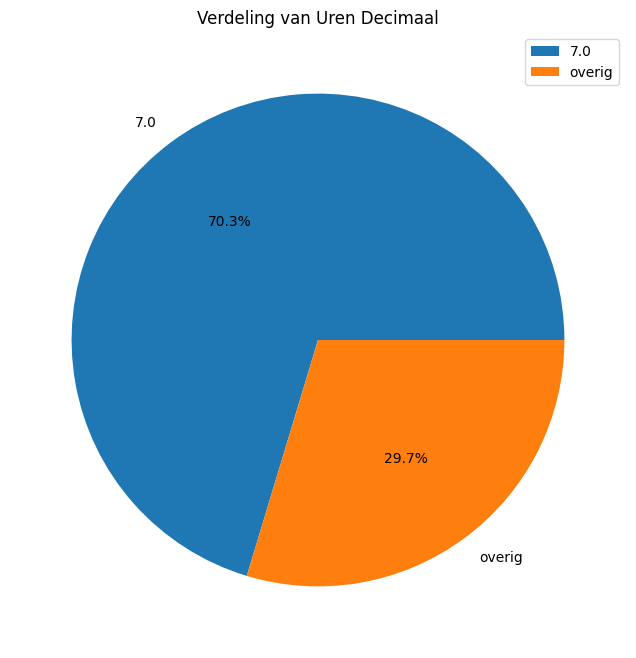

In [74]:
# Groepeer in grootste + overig
count_uren_pie = count_uren.copy()
grootste = count_uren_pie.iloc[0]
rest = count_uren_pie.iloc[1:]['count'].sum()

count_pie_grouped = pd.DataFrame({
    'uren_decimaal': [grootste['uren_decimaal'], 'overig'],
    'count': [grootste['count'], rest]
})

count_pie_grouped.plot.pie(y='count', labels=count_pie_grouped['uren_decimaal'], autopct='%1.1f%%', figsize=(8, 8), title='Verdeling van Uren Decimaal')
plt.show()

In [75]:
count_uren = df_orders_met_urenverantwoording['URENVERANTW_AANTAL'].value_counts().reset_index()
count_uren.columns = ['URENVERANTW_AANTAL', 'count']
count_uren.head(10)

,URENVERANTW_AANTAL,count
0,0.50,17290
1,0.25,11733
2,0.75,5411
3,1.00,5076
4,9.50,1880
5,9.00,1829
6,1.50,1819
7,2.00,1672
8,1.25,1608
9,8.75,1512


In [76]:
df_order_medewerkers = fetch_combined_data('TB_ORD_MEDEWERKER')
df_order_medewerkers.head()

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,ORDMED_ID,ORDMED_ORDERDAID,ORDMED_DIENSTARTID,ORDMED_ORDERREGELID,ORDMED_MEDID,ORDMED_MACHID,ORDMED_MACHGRPID,ORDMED_MEDGRPID,ORDMED_ORDMACHINE,ORDMED_GEPLAND,ORDMED_FIATAANTAL,ORDMED_STATUS,ORDMED_PLAN_START,ORDMED_PLAN_STOP,ORDMED_NOTITIE,ORDMED_NOTIFICATIE,ORDMED_MANDAGEN,con
0,1812,29601,None,30247,1004,None,None,None,None,NaN,0.0,0.0,07:00:00,16:00:00,NaN,NaN,1.25,23_hulter
1,1813,29634,None,30280,1011,None,None,None,None,NaN,0.0,0.0,07:00:00,16:00:00,NaN,NaN,8.00,23_hulter
2,1814,29635,None,30281,1011,None,None,None,None,0.0,NaN,0.0,07:00:00,16:00:00,NaN,NaN,8.00,23_hulter
3,1815,29636,None,30282,1011,None,None,None,None,0.0,NaN,0.0,07:00:00,16:00:00,NaN,NaN,8.00,23_hulter
4,1816,29637,None,30283,1011,None,None,None,None,0.0,NaN,0.0,07:00:00,16:00:00,NaN,NaN,8.00,23_hulter


In [77]:
df_order_medewerkers['ORDMED_ORDERDAID'].value_counts().head(10)

ORDMED_ORDERDAID
112330    18
112486    16
110660    13
111870    12
96865     11
110661    10
94458      9
107932     9
108339     9
112883     9
Name: count, dtype: int64

In [78]:
# Reset index en flatten multi-level columns voor merge
df_uren_flat = df_urenverantwoording_uren_gewerkt_order.reset_index()
df_uren_flat.columns = ['con', 'URENVERANTW_ORDERID', 'uren_sum', 'uren_count', 'medid_nunique']

df_order_uren = df_order.merge(df_uren_flat, left_on=["con", "ORD_ID"], right_on=["con", "URENVERANTW_ORDERID"])

In [79]:
df_order_uren.head()

,ORD_ID,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,con,VHO_TYPE,uren_decimaal,URENVERANTW_ORDERID,uren_sum,uren_count,medid_nunique
0,16268,NaN,NaN,10005,330,11452.0,None,15230.0,NaN,457,2023-02-13,2023-02-17,,None,None,None,None,None,None,,09:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,1221.199989,NaN,NaN,Arjan,None,-1.0,10:00:00,1,2023-02-17,0,None,None,2023-02-21 12:09:01,1005.0,Mest vanaf Huisjes,1477.651978,0,0.0,None,None,NaN,None,None,105.0,3.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,9.0,16268.0,2.00,2,1
1,16157,17.0,1083.0,10205,330,11484.0,None,15055.0,15118.0,352,2023-02-09,2023-02-09,,None,None,None,None,None,None,,10:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,312.980000,NaN,NaN,Marcel,None,-1.0,00:00:00,1,2023-02-09,0,None,None,2023-02-13 12:34:00,1005.0,,378.705811,0,0.0,None,None,NaN,None,None,104.0,5.0,3.0,NaN,1.0,NaN,NaN,Werkorder,None,None,23_hulter,NaN,10.0,16157.0,2.50,2,1
2,16594,NaN,NaN,10796,330,11598.0,None,15333.0,NaN,778,2023-02-22,2023-02-20,,None,None,None,None,None,None,,07:30:00,1.0,1,0.0,0.0,0.0,0.0,None,None,301.000000,NaN,NaN,Henk Reinders,None,-1.0,10:15:00,1,2023-02-20,0,None,None,NaT,1011.0,,364.209991,0,0.0,None,None,NaN,None,None,102.0,3.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,23_hulter,NaN,7.5,16594.0,4.50,3,1
3,19917,34.0,NaN,11427,330,NaN,None,17049.0,NaN,4070,2023-06-07,2023-06-07,,None,None,None,None,None,None,,11:30:00,1.0,2,0.0,0.0,0.0,0.0,None,None,112.500000,NaN,NaN,Wim Hulzebosch,None,-1.0,14:30:00,1,2023-06-07,0,None,None,2023-06-12 09:10:55,1038.0,is voor bonnen die niet gefactureerd worden aa...,136.125000,0,0.0,None,None,NaN,None,None,116.0,2.0,NaN,NaN,1.0,NaN,NaN,Werkorder,None,None,23_hulter,NaN,11.5,19917.0,3.50,2,1
4,16595,16.0,NaN,10099,330,NaN,None,NaN,NaN,779,2023-02-23,2023-02-23,,None,None,None,None,None,None,,06:30:00,1.0,2,NaN,0.0,NaN,0.0,None,None,247.500000,NaN,NaN,Wim Hofsink,None,NaN,00:00:00,1,2023-02-23,0,None,None,NaT,1084.0,,299.475006,0,0.0,None,None,NaN,None,None,105.0,0.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,23_hulter,NaN,6.5,16595.0,2.75,1,1


In [80]:
df_dienst_artikel_DA = fetch_combined_data('TB_ORDER_DA')
df_dienst_artikel_DA.head()

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,PARENT_ORD_DA_ID,TEKSTRG_ID,DAVOLGNUMMER,TEKSTRG_GRP_VOLG_NR,DA_AANGEMAAKTDOOR,DA_AANGEMAAKT_IN,con
0,33746,17456,10047,NaN,1892.0,1,2981.0,113.0,1,23_hulter
1,29575,15772,325,NaN,NaN,1,NaN,113.0,1,23_hulter
2,29576,15773,325,NaN,NaN,0,NaN,113.0,1,23_hulter
3,29577,15773,325,NaN,NaN,1,NaN,113.0,1,23_hulter
4,29578,15774,2000,NaN,NaN,1,NaN,113.0,1,23_hulter


In [81]:
df_dienst_artikel_DA_naam = df_dienst_artikel_DA[['con', 'ORD_ID', 'DIENST_ART_ID']]

In [82]:
df_dienst_artikel = fetch_combined_data('TB_DIENST_ARTIKEL')
df_dienst_artikel.head()

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,DIENST_ART_ID,KP_ID,TB__DIENST_ART_ID,ADM_ID,AFD_ID,DIENST_ART_CODE,DIENST_ART_TYPE,DIENST_ART_OMS,DIENST_ART_VOORRAAD,DIENST_ART_MAGID,DIENST_ART_STATUS,DIENST_ART_LINK,DIENST_ART_KORTING,DIENST_ART_OMREKENING,DIENST_ART_OMREKENINGOMS,DIENST_ART_OMREKVORM,DIENST_ART_TARIEFGROEPID,DIENST_ART_OPM,DIENST_ART_BLOKKEREN,DIENST_ART_PBG_ID,DIENST_ART_MUTDATE,BEWERKING_ID,DIENST_ART_APP_BLOKKEER,DIENST_ART_ORDERAPI,con
0,1,None,None,None,None,0001,1.0,AANGENOMEN WERK,None,None,None,None,None,0.0,None,NaN,115.0,None,0,None,2023-02-08 14:34:48.880,115.0,1.0,None,23_hulter
1,5,None,None,None,None,0005,1.0,AARDAPPELEN AANAARDFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:51:43.918,122.0,1.0,None,23_hulter
2,6,None,None,None,None,0006,1.0,AARDAPPELEN AANAARDFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:03.203,122.0,1.0,None,23_hulter
3,7,None,None,None,None,0007,1.0,AARDAPPELEN RUGGENFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:12.466,122.0,1.0,None,23_hulter
4,8,None,None,None,None,0008,1.0,AARDAPPELEN SCHOFFELTUIG HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:19.256,122.0,1.0,None,23_hulter


In [83]:
df_dienst_artikel_naam = df_dienst_artikel[['con', 'DIENST_ART_CODE', 'DIENST_ART_OMS', 'DIENST_ART_ID']]

In [84]:
df_diensten = df_dienst_artikel_DA_naam.merge(df_dienst_artikel_naam, how="inner", left_on=["con", "DIENST_ART_ID"], right_on=["con", "DIENST_ART_ID"])

In [85]:
df_diensten.head()

,con,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS
0,23_hulter,17456,10047,8503,RIJPLATEN HUUR FACT
1,23_hulter,15772,325,8999,DIVERSEN VERHUUR
2,23_hulter,15773,325,8999,DIVERSEN VERHUUR
3,23_hulter,15773,325,8999,DIVERSEN VERHUUR
4,23_hulter,15774,2000,9299,DIVERSEN VERKOOP


In [86]:
df = df_diensten.merge(df_orders_met_urenverantwoording, how="inner", left_on=["con", "ORD_ID"], right_on=["con", "ORD_ID"])

In [87]:
df.head()

,con,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS,uren_decimaal,URENVERANTW_AANTAL,URENVERANTW_ORDERID,verschil,verschil_uur
0,23_hulter,17456,10047,8503,RIJPLATEN HUUR FACT,13.0,1.25,17456.0,-11.75,-11
1,23_hulter,17918,10044,9006,TEELAARDE INCL. TR.,13.0,1.00,17918.0,-12.00,-12
2,23_hulter,16268,10032,10032,MEST AANGEVOERD,9.0,1.50,16268.0,-7.50,-7
3,23_hulter,16268,10032,10032,MEST AANGEVOERD,9.0,0.50,16268.0,-8.50,-8
4,23_hulter,16157,245,4003,VRACHTWAGEN TRANSPORT,10.0,2.00,16157.0,-8.00,-8


In [88]:
df['DIENST_ART_OMS'].value_counts()

DIENST_ART_OMS
Mobiele kraan 15-17 ton           9792
Grondwerker                       9674
Stratenmaker                      7874
Vakman GWW                        7641
Mini kraan 2 - 4 ton              7191
                                  ... 
Vrachttoeslag deelvrachten           1
Molmmest franco geleverd             1
Verk. PVC buis 500mm SN8             1
Verhuur opslagruimte buiten          1
Gladheidsbestrijding Eindhoven       1
Name: count, Length: 424, dtype: int64

In [89]:
stats = df.groupby('DIENST_ART_OMS')['verschil_uur'].agg(['mean', 'sum', 'count', 'std']).sort_values('sum', ascending=False)
stats

,mean,sum,count,std
DIENST_ART_OMS,,,,
AARDAPPELEN ROOIEN/LOOFKLAPPEN,0.333333,60,180,4.939862
BIETEN AANAARDEN,0.000000,0,1,NaN
MAAIDORSEN + VERHAKSELEN,0.000000,0,2,4.242641
MIDDELEN AARDAPPEL,-1.500000,-3,2,9.192388
Gladheidsbestrijding Eindhoven,-3.000000,-3,1,NaN
...,...,...,...,...
Stratenmaker,-3.733807,-29400,7874,3.750373
Mini kraan 2 - 4 ton,-4.311500,-31004,7191,3.464227
Vakman GWW,-4.221960,-32260,7641,3.508545


In [90]:
# Welke combinatie van uren_decimaal en URENVERANTW_AANTAL komt het vaakst voor
combo = df.groupby(['uren_decimaal', 'URENVERANTW_AANTAL']).size().reset_index(name='count').sort_values('count', ascending=False)
combo.head(10)

,uren_decimaal,URENVERANTW_AANTAL,count
503,7.0,0.50,36673
483,7.0,0.25,23877
520,7.0,0.75,10601
531,7.0,1.00,6590
705,7.0,9.50,5159
689,7.0,9.00,4441
682,7.0,8.75,3847
723,7.0,10.00,3224
715,7.0,9.75,2408
696,7.0,9.25,2357


In [91]:
# Voor elke combo: welke DIENST_ART_OMS komt het meest voor + totaal count
combo_dienst = df.groupby(['uren_decimaal', 'URENVERANTW_AANTAL', 'DIENST_ART_OMS']).size().reset_index(name='count')
combo_totaal = df.groupby(['uren_decimaal', 'URENVERANTW_AANTAL']).size().reset_index(name='totaal_count')

combo_dienst = combo_dienst.sort_values(['uren_decimaal', 'URENVERANTW_AANTAL', 'count'], ascending=[True, True, False])
combo_dienst = combo_dienst.drop_duplicates(['uren_decimaal', 'URENVERANTW_AANTAL'], keep='first')
combo_dienst = combo_dienst.merge(combo_totaal, on=['uren_decimaal', 'URENVERANTW_AANTAL'])
combo_dienst.sort_values('totaal_count', ascending=False).head(15)

,uren_decimaal,URENVERANTW_AANTAL,DIENST_ART_OMS,count,totaal_count
503,7.0,0.50,Mobiele kraan 15-17 ton,2907,36673
483,7.0,0.25,Grondwerker,1945,23877
520,7.0,0.75,MOBIELE KRAAN,2201,10601
531,7.0,1.00,Grondwerker,726,6590
705,7.0,9.50,MOBIELE KRAAN,1086,5159
689,7.0,9.00,Mini kraan 2 - 4 ton,548,4441
682,7.0,8.75,MOBIELE KRAAN,1022,3847
723,7.0,10.00,Stratenmaker,284,3224
715,7.0,9.75,Stratenmaker,268,2408
696,7.0,9.25,Vakman GWW,217,2357


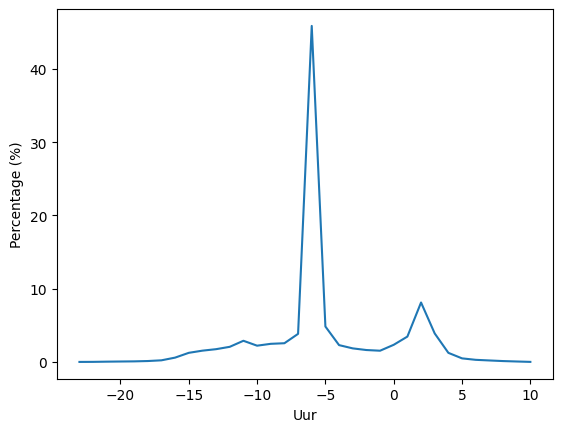

In [92]:
percentages = (counts / counts.sum()) * 100
percentages.plot(kind='line')
plt.xlabel('Uur')
plt.ylabel('Percentage (%)')
plt.show()

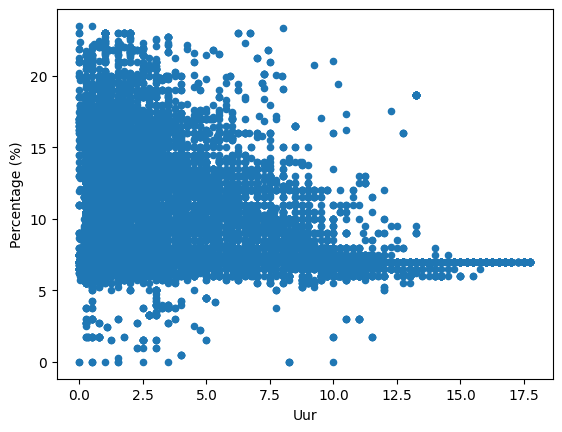

In [93]:
df.plot(kind='scatter', y='uren_decimaal', x='URENVERANTW_AANTAL' )
plt.xlabel('Uur')
plt.ylabel('Percentage (%)')
plt.show()

In [94]:
df_verschil = pd.DataFrame({
    'uur_verschil': counts.index,
    'aantal': counts.values
})
df_verschil = df_verschil.sort_values(by='aantal', ascending=False)

In [95]:
# Bereken percentage en groepeer < 4% als 'overig'
df_pie = df_verschil.copy()
df_pie['percentage'] = 100 * df_pie['aantal'] / df_pie['aantal'].sum()

klein = df_pie[df_pie['percentage'] < 4]['aantal'].sum()
df_pie = df_pie[df_pie['percentage'] >= 4]

df_pie = pd.concat([df_pie, pd.DataFrame({'uur_verschil': ['overig'], 'aantal': [klein], 'percentage': [100 - df_pie['percentage'].sum()]})], ignore_index=True)

In [96]:
df_pie

,uur_verschil,aantal,percentage
0,-6,33292,45.887088
1,2,5891,8.119693
2,-5,3511,4.839288
3,overig,29858,41.153931


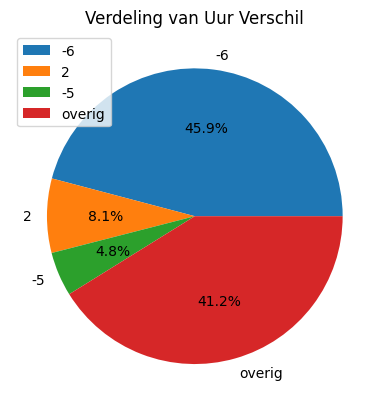

In [97]:
df_pie.plot.pie(y='aantal', labels=df_pie['uur_verschil'], autopct='%1.1f%%')
plt.title('Verdeling van Uur Verschil')
plt.show()

In [98]:
df_prijsregel = fetch_combined_data('TB_PRIJS_REGEL')
df_prijsregel.head()

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,PRIJSRG_ID,EENHEID_ID,BTW_ID,DIENSTTYPE_ID,ARTIKELGROEP_ID,PRIJSRG_CODE,PRIJSRG_OMS,PRIJSRG_PRIJS,PRIJSRG_REKENREGEL,PRIJSRG_ISDIENST,PRIJSRG_AFDRUKKEN,PRIJSRG_INKOOPSPRIJS,PRIJSRG_VOORRAAD,PRIJSRG_MUTDATUM,KP_ID,PRIJSRG_VOORRAADBIJHOUDEN,PRIJSRG_LEVID,PRIJSRG_INKOOPCODE,PRIJSRG_KP_VOLGENS_BTW,PRIJSRG_MINAS_PRODUCT,PRIJSRG_KG_KGDS,PRIJSRG_P_P2O5,PRIJSRG_N_RE,PRIJSRG_MACHGROP_ID,PRIJSRG_DEF_MACH_ID,PRIJSRG_DEF_WERKTUIG_ID,PRIJSRG_NAARMIMIS,PRIJSRG_CALCULATIEPRIJS,PRIJSRG_3DEC_OP_FACT,PRIJSRG_APP_BLOKKEER,PRIJSRG_NAARUNIWIN,PRIJSRG_TOESLAG_ID,con
0,1,NaN,3,1,NaN,0001,Aangenomen werk,NaN,None,1,1,NaN,-28.0,2024-01-05 09:36:08.101,257.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
1,2,647.0,3,1,NaN,0005,Aardappelen aanaardfrees huur,35.0,None,1,1,NaN,-31.0,2024-01-05 09:36:08.117,269.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
2,3,645.0,3,1,NaN,0006,Aardappelen aanaardfrees huur,35.0,None,1,1,NaN,-10.5,2024-01-05 09:36:08.132,269.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
3,4,647.0,3,1,NaN,0007,Aardappelen ruggenfrees huur,30.0,None,1,1,NaN,-3.0,2024-01-05 09:36:08.148,269.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
4,6,645.0,3,1,NaN,0009,Aardappelen schoffeltuig huur,15.0,None,1,1,NaN,0.0,2024-01-05 09:36:08.148,269.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter


In [99]:
df_prijsregel.info()

<class 'pandas.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PRIJSRG_ID                 1774 non-null   int64         
 1   EENHEID_ID                 1703 non-null   float64       
 2   BTW_ID                     1774 non-null   int64         
 3   DIENSTTYPE_ID              1774 non-null   int64         
 4   ARTIKELGROEP_ID            5 non-null      float64       
 5   PRIJSRG_CODE               1768 non-null   str           
 6   PRIJSRG_OMS                1774 non-null   str           
 7   PRIJSRG_PRIJS              1567 non-null   float64       
 8   PRIJSRG_REKENREGEL         0 non-null      object        
 9   PRIJSRG_ISDIENST           1774 non-null   int64         
 10  PRIJSRG_AFDRUKKEN          1774 non-null   int64         
 11  PRIJSRG_INKOOPSPRIJS       34 non-null     float64       
 12  PRIJSRG_VOORRAAD 

In [100]:
prijsregel_aantal_uniek = df_prijsregel["PRIJSRG_CODE"].nunique()

In [101]:
df_dienst_artikel = fetch_combined_data('TB_DIENST_ARTIKEL')
df_dienst_artikel.head()

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


,DIENST_ART_ID,KP_ID,TB__DIENST_ART_ID,ADM_ID,AFD_ID,DIENST_ART_CODE,DIENST_ART_TYPE,DIENST_ART_OMS,DIENST_ART_VOORRAAD,DIENST_ART_MAGID,DIENST_ART_STATUS,DIENST_ART_LINK,DIENST_ART_KORTING,DIENST_ART_OMREKENING,DIENST_ART_OMREKENINGOMS,DIENST_ART_OMREKVORM,DIENST_ART_TARIEFGROEPID,DIENST_ART_OPM,DIENST_ART_BLOKKEREN,DIENST_ART_PBG_ID,DIENST_ART_MUTDATE,BEWERKING_ID,DIENST_ART_APP_BLOKKEER,DIENST_ART_ORDERAPI,con
0,1,None,None,None,None,0001,1.0,AANGENOMEN WERK,None,None,None,None,None,0.0,None,NaN,115.0,None,0,None,2023-02-08 14:34:48.880,115.0,1.0,None,23_hulter
1,5,None,None,None,None,0005,1.0,AARDAPPELEN AANAARDFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:51:43.918,122.0,1.0,None,23_hulter
2,6,None,None,None,None,0006,1.0,AARDAPPELEN AANAARDFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:03.203,122.0,1.0,None,23_hulter
3,7,None,None,None,None,0007,1.0,AARDAPPELEN RUGGENFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:12.466,122.0,1.0,None,23_hulter
4,8,None,None,None,None,0008,1.0,AARDAPPELEN SCHOFFELTUIG HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:19.256,122.0,1.0,None,23_hulter


In [102]:
df_dienst_artikel.info()

<class 'pandas.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIENST_ART_ID             1476 non-null   int64         
 1   KP_ID                     0 non-null      object        
 2   TB__DIENST_ART_ID         0 non-null      object        
 3   ADM_ID                    0 non-null      object        
 4   AFD_ID                    0 non-null      object        
 5   DIENST_ART_CODE           1476 non-null   str           
 6   DIENST_ART_TYPE           1383 non-null   float64       
 7   DIENST_ART_OMS            1476 non-null   str           
 8   DIENST_ART_VOORRAAD       0 non-null      object        
 9   DIENST_ART_MAGID          0 non-null      object        
 10  DIENST_ART_STATUS         0 non-null      object        
 11  DIENST_ART_LINK           0 non-null      object        
 12  DIENST_ART_KORTING        0 non

In [103]:
dienst_artiekelen_uniek = df_dienst_artikel["DIENST_ART_CODE"].nunique()

In [104]:
prijsregels_niet_in_dienst_artikelen = prijsregel_aantal_uniek - dienst_artiekelen_uniek

In [105]:
print(prijsregels_niet_in_dienst_artikelen)

129


In [106]:
#hoeveel dienst artikelen hebben meerdere prijsregels?
meerdere_prijsregels_per_dienst_artikel = df_prijsregel.groupby("PRIJSRG_CODE").size()
meerdere_prijsregels_per_dienst_artikel = meerdere_prijsregels_per_dienst_artikel[meerdere_prijsregels_per_dienst_artikel > 1]
print(meerdere_prijsregels_per_dienst_artikel)

PRIJSRG_CODE
0001       3
0005       3
0006       3
0007       3
0009       3
          ..
9998       2
9999       2
KOPER      3
MANTRAC    2
MOLYTAC    3
Length: 631, dtype: int64


In [107]:
# welke prijsregels hebben geen dienst artikelen?
prijsregels_zonder_dienst_artikel = df_prijsregel[~df_prijsregel["PRIJSRG_CODE"].isin(df_dienst_artikel["DIENST_ART_CODE"])]
prijsregels_zonder_dienst_artikel

,PRIJSRG_ID,EENHEID_ID,BTW_ID,DIENSTTYPE_ID,ARTIKELGROEP_ID,PRIJSRG_CODE,PRIJSRG_OMS,PRIJSRG_PRIJS,PRIJSRG_REKENREGEL,PRIJSRG_ISDIENST,PRIJSRG_AFDRUKKEN,PRIJSRG_INKOOPSPRIJS,PRIJSRG_VOORRAAD,PRIJSRG_MUTDATUM,KP_ID,PRIJSRG_VOORRAADBIJHOUDEN,PRIJSRG_LEVID,PRIJSRG_INKOOPCODE,PRIJSRG_KP_VOLGENS_BTW,PRIJSRG_MINAS_PRODUCT,PRIJSRG_KG_KGDS,PRIJSRG_P_P2O5,PRIJSRG_N_RE,PRIJSRG_MACHGROP_ID,PRIJSRG_DEF_MACH_ID,PRIJSRG_DEF_WERKTUIG_ID,PRIJSRG_NAARMIMIS,PRIJSRG_CALCULATIEPRIJS,PRIJSRG_3DEC_OP_FACT,PRIJSRG_APP_BLOKKEER,PRIJSRG_NAARUNIWIN,PRIJSRG_TOESLAG_ID,con
7,9,647.0,3,1,NaN,1100A,Aardappelen poten,75.00,None,1,1,NaN,-248.270004,2024-01-05 09:36:08.195,233.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
8,10,645.0,3,1,NaN,1100B,Aardappelen poten,75.00,None,1,0,NaN,-306.750000,2024-01-05 09:36:08.210,233.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
9,11,647.0,3,1,NaN,1105A,Aardappelen rooien/loofklappen (4-rijer),200.00,None,1,1,NaN,-257.470001,2024-01-09 14:06:59.614,232.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
10,12,645.0,3,1,NaN,1105B,Aardappelen rooien/loofklappen (4-rijer),120.00,None,1,0,NaN,-525.000000,2024-01-09 14:03:44.814,232.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
22,24,649.0,3,1,NaN,0045A,Bouwland injecteren,3.25,None,1,1,NaN,-26720.000000,2024-01-05 09:36:08.398,222.0,1.0,None,None,0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,23_hulter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,20069,705.0,3,2,NaN,3025,Metselzand,30.00,None,0,1,NaN,0.000000,2025-01-06 14:32:32.271,NaN,1.0,NaN,None,1,None,None,None,None,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,25_kuijpers
1535,20083,645.0,3,1,NaN,1502,Containerauto 6x4 met laadkraan,75.00,None,0,1,NaN,0.000000,2025-01-06 14:32:32.299,NaN,1.0,10338.0,None,1,None,None,None,None,7.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,25_kuijpers
1566,20177,655.0,3,1,NaN,1030B,Dieseltoeslag,1.75,None,0,1,NaN,0.000000,2025-01-06 14:32:32.547,NaN,1.0,NaN,None,1,None,None,None,None,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,25_kuijpers
1591,20178,655.0,3,1,NaN,1401B,Dieseltoeslag,0.25,None,0,1,NaN,0.000000,2025-01-06 14:32:32.718,NaN,1.0,NaN,None,1,None,None,None,None,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,25_kuijpers


# Data prep

## TB_URENVERANTWOORDING

In [108]:
TB_URENVERANTWOORDING = fetch_combined_data('TB_URENVERANTWOORDING')

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


In [109]:
TB_URENVERANTWOORDING.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con
0,2102,2023-01-04,NaN,11677.0,1,1.25,None,1004,15783.0,29601.0,1812.0,01:15,30247.0,None,None,1,2023,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
1,2103,2023-01-09,NaN,10161.0,1,8.00,None,1011,15800.0,29634.0,1813.0,08:00,30280.0,None,None,2,2023,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
2,2104,2023-01-10,NaN,10161.0,1,8.00,None,1011,15800.0,29635.0,1814.0,08:00,30281.0,None,None,2,2023,,,0.0,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
3,2105,2023-01-11,NaN,10161.0,1,8.00,None,1011,15800.0,29636.0,1815.0,08:00,30282.0,None,None,2,2023,,,0.0,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter
4,2106,2023-01-12,NaN,10161.0,1,8.00,None,1011,15800.0,29637.0,1816.0,08:00,30283.0,None,None,2,2023,,,0.0,None,NaN,None,NaN,NaN,NaN,None,None,23_hulter


In [110]:
TB_URENVERANTWOORDING = TB_URENVERANTWOORDING[~TB_URENVERANTWOORDING['URENVERANTW_TIJDSOORT'].isin([1])]

In [111]:
TB_URENVERANTWOORDING_tijdsoort3 = TB_URENVERANTWOORDING[TB_URENVERANTWOORDING['URENVERANTW_TIJDSOORT'].isin([3])]

In [112]:
TB_URENVERANTWOORDING_overig = TB_URENVERANTWOORDING[~TB_URENVERANTWOORDING['URENVERANTW_TIJDSOORT'].isin([3])]

In [113]:
uren_afrek = TB_URENVERANTWOORDING_overig.groupby([
    'con',
    'URENVERANTW_ORDERID', 
    'URENVERANTW_DATUM', 
    'URENVERANTW_MEDID'
])['URENVERANTW_AANTAL'].sum().reset_index()
uren_afrek = uren_afrek.rename(columns={'URENVERANTW_AANTAL': 'aftrek_tijd'})


In [114]:
TB_URENVERANTWOORDING_tijdsoort3.info()

<class 'pandas.DataFrame'>
Index: 36482 entries, 84 to 100049
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   URENVERANTW_ID              36482 non-null  int64  
 1   URENVERANTW_DATUM           36482 non-null  object 
 2   URENVERANTW_PROJID          1880 non-null   float64
 3   URENVERANTW_RELATIEID       36396 non-null  float64
 4   URENVERANTW_TIJDSOORT       36482 non-null  int64  
 5   URENVERANTW_AANTAL          36482 non-null  float64
 6   URENVERANTW_MACHID          0 non-null      object 
 7   URENVERANTW_MEDID           36482 non-null  int64  
 8   URENVERANTW_ORDERID         36419 non-null  float64
 9   URENVERANTW_ORDDAID         36419 non-null  float64
 10  URENVERANTW_ORDMEDID        36419 non-null  float64
 11  URENVERANTW_TIJD            36482 non-null  str    
 12  URENVERANTW_ORDRG_ID        36419 non-null  float64
 13  URENVERANTW_GROEPSID        13 non-null     o

In [115]:
TB_URENVERANTWOORDING_gecorrigeerd = TB_URENVERANTWOORDING_tijdsoort3.merge(
    uren_afrek, 
    on=['con', 'URENVERANTW_ORDERID', 'URENVERANTW_DATUM', 'URENVERANTW_MEDID'], 
    how='left'
)

In [116]:
uren_afrek.head()

,con,URENVERANTW_ORDERID,URENVERANTW_DATUM,URENVERANTW_MEDID,aftrek_tijd
0,23_hulter,16117.0,2023-02-09,1005,0.25
1,23_hulter,16157.0,2023-02-09,1005,0.50
2,23_hulter,16165.0,2023-02-10,1006,1.00
3,23_hulter,16175.0,2023-02-13,1005,0.75
4,23_hulter,16176.0,2023-02-23,1004,0.50


In [117]:
TB_URENVERANTWOORDING_gecorrigeerd['aftrek_tijd'] = TB_URENVERANTWOORDING_gecorrigeerd['aftrek_tijd'].fillna(0)
TB_URENVERANTWOORDING_gecorrigeerd['URENVERANTW_AANTAL_GECORRIGEERD'] = (
    TB_URENVERANTWOORDING_gecorrigeerd['URENVERANTW_AANTAL'] - 
    TB_URENVERANTWOORDING_gecorrigeerd['aftrek_tijd']
)

In [118]:
TB_URENVERANTWOORDING_gecorrigeerd['URENVERANTW_AANTAL_GECORRIGEERD'] = (
    (TB_URENVERANTWOORDING_gecorrigeerd['URENVERANTW_AANTAL_GECORRIGEERD'] * 4).round() / 4
)

In [119]:
TB_URENVERANTWOORDING_gecorrigeerd.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,1.25,8.50
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,0.50,4.50
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,0.00,0.75
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,1.00,9.50
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.00,659.0,None,None,23_hulter,0.00,2.50


In [120]:
TB_URENVERANTWOORDING_gecorrigeerd.info()

<class 'pandas.DataFrame'>
RangeIndex: 36482 entries, 0 to 36481
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   36482 non-null  int64  
 1   URENVERANTW_DATUM                36482 non-null  object 
 2   URENVERANTW_PROJID               1880 non-null   float64
 3   URENVERANTW_RELATIEID            36396 non-null  float64
 4   URENVERANTW_TIJDSOORT            36482 non-null  int64  
 5   URENVERANTW_AANTAL               36482 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                36482 non-null  int64  
 8   URENVERANTW_ORDERID              36419 non-null  float64
 9   URENVERANTW_ORDDAID              36419 non-null  float64
 10  URENVERANTW_ORDMEDID             36419 non-null  float64
 11  URENVERANTW_TIJD                 36482 non-null  str    
 12  URENVERANTW_ORDRG_ID         

## TB_ORDER_DA

In [121]:
TB_ORDER_DA = fetch_combined_data('TB_ORDER_DA')

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


In [122]:
TB_ORDER_DA.head()

,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,PARENT_ORD_DA_ID,TEKSTRG_ID,DAVOLGNUMMER,TEKSTRG_GRP_VOLG_NR,DA_AANGEMAAKTDOOR,DA_AANGEMAAKT_IN,con
0,33746,17456,10047,NaN,1892.0,1,2981.0,113.0,1,23_hulter
1,29575,15772,325,NaN,NaN,1,NaN,113.0,1,23_hulter
2,29576,15773,325,NaN,NaN,0,NaN,113.0,1,23_hulter
3,29577,15773,325,NaN,NaN,1,NaN,113.0,1,23_hulter
4,29578,15774,2000,NaN,NaN,1,NaN,113.0,1,23_hulter


In [123]:
TB_ORDER_DA = TB_ORDER_DA[['con', 'ORDER_DA_ID', 'ORD_ID', 'DIENST_ART_ID']]

In [124]:
TB_ORDER_DA.head()

,con,ORDER_DA_ID,ORD_ID,DIENST_ART_ID
0,23_hulter,33746,17456,10047
1,23_hulter,29575,15772,325
2,23_hulter,29576,15773,325
3,23_hulter,29577,15773,325
4,23_hulter,29578,15774,2000


In [125]:
TB_URENVERANTWOORDING_gecorrigeerd.info()

<class 'pandas.DataFrame'>
RangeIndex: 36482 entries, 0 to 36481
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   36482 non-null  int64  
 1   URENVERANTW_DATUM                36482 non-null  object 
 2   URENVERANTW_PROJID               1880 non-null   float64
 3   URENVERANTW_RELATIEID            36396 non-null  float64
 4   URENVERANTW_TIJDSOORT            36482 non-null  int64  
 5   URENVERANTW_AANTAL               36482 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                36482 non-null  int64  
 8   URENVERANTW_ORDERID              36419 non-null  float64
 9   URENVERANTW_ORDDAID              36419 non-null  float64
 10  URENVERANTW_ORDMEDID             36419 non-null  float64
 11  URENVERANTW_TIJD                 36482 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [126]:
TB_ORDER_DA.info()

<class 'pandas.DataFrame'>
RangeIndex: 86174 entries, 0 to 86173
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   con            86174 non-null  str  
 1   ORDER_DA_ID    86174 non-null  int64
 2   ORD_ID         86174 non-null  int64
 3   DIENST_ART_ID  86174 non-null  int64
dtypes: int64(3), str(1)
memory usage: 2.6 MB


In [127]:
df = TB_URENVERANTWOORDING_gecorrigeerd.merge(
    TB_ORDER_DA,
    left_on=['con', 'URENVERANTW_ORDDAID'],
    right_on=['con', 'ORDER_DA_ID'],
    how='left'
)

In [128]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36482 entries, 0 to 36481
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   36482 non-null  int64  
 1   URENVERANTW_DATUM                36482 non-null  object 
 2   URENVERANTW_PROJID               1880 non-null   float64
 3   URENVERANTW_RELATIEID            36396 non-null  float64
 4   URENVERANTW_TIJDSOORT            36482 non-null  int64  
 5   URENVERANTW_AANTAL               36482 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                36482 non-null  int64  
 8   URENVERANTW_ORDERID              36419 non-null  float64
 9   URENVERANTW_ORDDAID              36419 non-null  float64
 10  URENVERANTW_ORDMEDID             36419 non-null  float64
 11  URENVERANTW_TIJD                 36482 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [129]:
df.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,1.25,8.50,31001.0,16565.0,300.0
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,0.50,4.50,30462.0,16254.0,259.0
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,0.00,0.75,30291.0,16164.0,221.0
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,1.00,9.50,32353.0,17334.0,215.0
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.00,659.0,None,None,23_hulter,0.00,2.50,30273.0,16151.0,221.0


## TB_DIENST_ARTIKEL

In [130]:
TB_DIENST_ARTIKEL = fetch_combined_data('TB_DIENST_ARTIKEL')

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


In [131]:
TB_DIENST_ARTIKEL.info()

<class 'pandas.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIENST_ART_ID             1476 non-null   int64         
 1   KP_ID                     0 non-null      object        
 2   TB__DIENST_ART_ID         0 non-null      object        
 3   ADM_ID                    0 non-null      object        
 4   AFD_ID                    0 non-null      object        
 5   DIENST_ART_CODE           1476 non-null   str           
 6   DIENST_ART_TYPE           1383 non-null   float64       
 7   DIENST_ART_OMS            1476 non-null   str           
 8   DIENST_ART_VOORRAAD       0 non-null      object        
 9   DIENST_ART_MAGID          0 non-null      object        
 10  DIENST_ART_STATUS         0 non-null      object        
 11  DIENST_ART_LINK           0 non-null      object        
 12  DIENST_ART_KORTING        0 non

In [132]:
TB_DIENST_ARTIKEL.head()

,DIENST_ART_ID,KP_ID,TB__DIENST_ART_ID,ADM_ID,AFD_ID,DIENST_ART_CODE,DIENST_ART_TYPE,DIENST_ART_OMS,DIENST_ART_VOORRAAD,DIENST_ART_MAGID,DIENST_ART_STATUS,DIENST_ART_LINK,DIENST_ART_KORTING,DIENST_ART_OMREKENING,DIENST_ART_OMREKENINGOMS,DIENST_ART_OMREKVORM,DIENST_ART_TARIEFGROEPID,DIENST_ART_OPM,DIENST_ART_BLOKKEREN,DIENST_ART_PBG_ID,DIENST_ART_MUTDATE,BEWERKING_ID,DIENST_ART_APP_BLOKKEER,DIENST_ART_ORDERAPI,con
0,1,None,None,None,None,0001,1.0,AANGENOMEN WERK,None,None,None,None,None,0.0,None,NaN,115.0,None,0,None,2023-02-08 14:34:48.880,115.0,1.0,None,23_hulter
1,5,None,None,None,None,0005,1.0,AARDAPPELEN AANAARDFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:51:43.918,122.0,1.0,None,23_hulter
2,6,None,None,None,None,0006,1.0,AARDAPPELEN AANAARDFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:03.203,122.0,1.0,None,23_hulter
3,7,None,None,None,None,0007,1.0,AARDAPPELEN RUGGENFREES HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:12.466,122.0,1.0,None,23_hulter
4,8,None,None,None,None,0008,1.0,AARDAPPELEN SCHOFFELTUIG HUUR,None,None,None,None,None,0.0,None,NaN,109.0,None,0,None,2023-03-31 10:52:19.256,122.0,1.0,None,23_hulter


In [133]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36482 entries, 0 to 36481
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   36482 non-null  int64  
 1   URENVERANTW_DATUM                36482 non-null  object 
 2   URENVERANTW_PROJID               1880 non-null   float64
 3   URENVERANTW_RELATIEID            36396 non-null  float64
 4   URENVERANTW_TIJDSOORT            36482 non-null  int64  
 5   URENVERANTW_AANTAL               36482 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                36482 non-null  int64  
 8   URENVERANTW_ORDERID              36419 non-null  float64
 9   URENVERANTW_ORDDAID              36419 non-null  float64
 10  URENVERANTW_ORDMEDID             36419 non-null  float64
 11  URENVERANTW_TIJD                 36482 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [134]:
df = df.merge(
    TB_DIENST_ARTIKEL[['con', 'DIENST_ART_ID', 'DIENST_ART_CODE', 'DIENST_ART_OMS']],
    left_on=['con', 'DIENST_ART_ID'],
    right_on=['con', 'DIENST_ART_ID'],
    how='left'
)

In [135]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36482 entries, 0 to 36481
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   36482 non-null  int64  
 1   URENVERANTW_DATUM                36482 non-null  object 
 2   URENVERANTW_PROJID               1880 non-null   float64
 3   URENVERANTW_RELATIEID            36396 non-null  float64
 4   URENVERANTW_TIJDSOORT            36482 non-null  int64  
 5   URENVERANTW_AANTAL               36482 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                36482 non-null  int64  
 8   URENVERANTW_ORDERID              36419 non-null  float64
 9   URENVERANTW_ORDDAID              36419 non-null  float64
 10  URENVERANTW_ORDMEDID             36419 non-null  float64
 11  URENVERANTW_TIJD                 36482 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [136]:
df.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,1.25,8.50,31001.0,16565.0,300.0,0300,DRAINAGE SCHOONSPUITEN
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,0.50,4.50,30462.0,16254.0,259.0,0259,MESTSTROOIER
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,0.00,0.75,30291.0,16164.0,221.0,4004,CONTAINER AAN- EN AFVOER
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,1.00,9.50,32353.0,17334.0,215.0,0215,WERKPLAATS MONTEUR
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.00,659.0,None,None,23_hulter,0.00,2.50,30273.0,16151.0,221.0,4004,CONTAINER AAN- EN AFVOER


## TB_ORDERREGEL

In [137]:
TB_ORDERREGEL = fetch_combined_data('TB_ORDERREGEL')

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


In [138]:
TB_ORDERREGEL.info()

<class 'pandas.DataFrame'>
RangeIndex: 92311 entries, 0 to 92310
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ORDRG_ID                   92311 non-null  int64  
 1   ORDER_DA_ID                92311 non-null  int64  
 2   PRIJSVOLG_ID               92311 non-null  int64  
 3   BTW_ID                     92301 non-null  float64
 4   EENHEID_ID                 91340 non-null  float64
 5   ORDRG_VOLGNR               92251 non-null  float64
 6   ORDRG_HOEVEELHEID          91394 non-null  float64
 7   ORDRG_PRIJS                92166 non-null  float64
 8   ORDRG_OMS                  92311 non-null  str    
 9   PARENT_ORDRG_ID            35405 non-null  float64
 10  ORDRG_KORTING              89356 non-null  float64
 11  ORDRG_TEKSTONDER           52208 non-null  str    
 12  ORDRG_DATUM                92304 non-null  object 
 13  PROJECT_OMS                0 non-null      object 
 14  P

In [139]:
TB_ORDERREGEL.info()

<class 'pandas.DataFrame'>
RangeIndex: 92311 entries, 0 to 92310
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ORDRG_ID                   92311 non-null  int64  
 1   ORDER_DA_ID                92311 non-null  int64  
 2   PRIJSVOLG_ID               92311 non-null  int64  
 3   BTW_ID                     92301 non-null  float64
 4   EENHEID_ID                 91340 non-null  float64
 5   ORDRG_VOLGNR               92251 non-null  float64
 6   ORDRG_HOEVEELHEID          91394 non-null  float64
 7   ORDRG_PRIJS                92166 non-null  float64
 8   ORDRG_OMS                  92311 non-null  str    
 9   PARENT_ORDRG_ID            35405 non-null  float64
 10  ORDRG_KORTING              89356 non-null  float64
 11  ORDRG_TEKSTONDER           52208 non-null  str    
 12  ORDRG_DATUM                92304 non-null  object 
 13  PROJECT_OMS                0 non-null      object 
 14  P

In [140]:
TB_ORDERREGEL.head()

,ORDRG_ID,ORDER_DA_ID,PRIJSVOLG_ID,BTW_ID,EENHEID_ID,ORDRG_VOLGNR,ORDRG_HOEVEELHEID,ORDRG_PRIJS,ORDRG_OMS,PARENT_ORDRG_ID,ORDRG_KORTING,ORDRG_TEKSTONDER,ORDRG_DATUM,PROJECT_OMS,PROJECTSOORT_OMS,PROJECTSOORT_PRINT,ORDRG_DOCUMENT,PROJ_ID,ORDRG_DS,ORDRG_P2O5,ORDRG_N,ORDRG_P,ORDRG_RE,ORDRG_CATGR_ID,ORDRG_FACTUURBEDRAG,ORDRG_MACHINE_ID,ORDRG_WERKTUIG_ID,ORDRG_INPLANNEN,ORDRG_GEPLAND,ORDRG_MAILVOLGNR,ORDRG_FIATAANTAL,CREDITEUR_ID,ORDRG_INKOOPPRIJS,ORDRG_INKOOPBEDRAG,INKOOPFACTUURREGEL_ID,ORDRG_WEERTYPE_ID,ORDRG_PBG_ID,ORDRG_CALCULATIEPRIJS,ORDRG_PBGTOTBEDRAG,ORDRG_TONENINLIJST,ORDRG_BSTK_PST_ID,ORDRG_KOSTENPLAATS_ID,ORDRG_PRIJSRG_ID,ORD_ID,ORDRG_VERK_PLR_ID,ORDRG_INK_PLR_ID,ORDRG_PLANSTART,ORDRG_PLANSTOP,ORDRG_INKOOPVORIGBOEKJAAR,ORDRG_TOESLAG_ID,ORDRG_TOESLAG,INK_ORDER_ID,con
0,34764,33746,10077,3.0,652.0,1.0,21.0,5.0,Huur 10 stuks rijplaten van 28-02-23 t/m 28-03...,0.0,0.0,NaN,2023-03-28,None,None,None,None,None,None,None,None,None,None,None,105.0,None,None,0.0,0.0,0.0,0.0,NaN,NaN,0.0,None,None,None,NaN,0.0,0.0,None,None,10068,17456,NaN,NaN,13:00:00,15:00:00,0,None,NaN,None,23_hulter
1,30221,29575,201,3.0,651.0,1.0,1.0,150.0,Huur aardappelbak voor de mobiele kraan,0.0,0.0,NaN,2022-11-25,None,None,None,None,None,None,None,None,None,None,None,150.0,None,None,1.0,0.0,0.0,0.0,NaN,NaN,0.0,None,None,None,NaN,0.0,0.0,None,None,201,15772,NaN,NaN,07:00:00,16:00:00,0,None,NaN,None,23_hulter
2,30222,29576,201,3.0,NaN,0.0,0.0,0.0,vanaf 05-12-22 35m3 container in gebruik,0.0,0.0,NaN,2022-12-05,None,None,None,None,None,None,None,None,None,None,None,0.0,None,None,1.0,0.0,0.0,0.0,NaN,NaN,0.0,None,None,None,NaN,0.0,0.0,None,None,201,15773,NaN,NaN,07:00:00,16:00:00,0,None,NaN,None,23_hulter
3,30223,29577,201,3.0,NaN,0.0,0.0,0.0,vanaf 09-12-22 2e 35m3 container in gebruik,30222.0,0.0,NaN,1900-01-08,None,None,None,None,None,None,None,None,None,None,None,0.0,None,None,1.0,0.0,0.0,NaN,NaN,NaN,0.0,None,None,None,NaN,0.0,0.0,None,None,201,15773,NaN,NaN,07:00:00,16:00:00,0,None,NaN,None,23_hulter
4,30224,29578,237,3.0,NaN,1.0,1.0,1180.0,Schade rolkleed,0.0,0.0,"(bedrag is exkl. toeslag, factuur ontvangen va...",2022-04-05,None,None,None,None,None,None,None,None,None,None,None,1180.0,None,None,1.0,0.0,0.0,0.0,NaN,NaN,0.0,None,None,None,NaN,0.0,0.0,None,None,237,15774,NaN,NaN,07:00:00,16:00:00,0,None,NaN,None,23_hulter


In [141]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36482 entries, 0 to 36481
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   36482 non-null  int64  
 1   URENVERANTW_DATUM                36482 non-null  object 
 2   URENVERANTW_PROJID               1880 non-null   float64
 3   URENVERANTW_RELATIEID            36396 non-null  float64
 4   URENVERANTW_TIJDSOORT            36482 non-null  int64  
 5   URENVERANTW_AANTAL               36482 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                36482 non-null  int64  
 8   URENVERANTW_ORDERID              36419 non-null  float64
 9   URENVERANTW_ORDDAID              36419 non-null  float64
 10  URENVERANTW_ORDMEDID             36419 non-null  float64
 11  URENVERANTW_TIJD                 36482 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [142]:
df =df.merge(
    TB_ORDERREGEL[['con', 'ORDRG_ID', 'ORDER_DA_ID', 'ORDRG_HOEVEELHEID', 'EENHEID_ID', 'ORDRG_OMS']],
    on=['con', 'ORDER_DA_ID'],
    how='left'
)

In [143]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 41193 entries, 0 to 41192
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   41193 non-null  int64  
 1   URENVERANTW_DATUM                41193 non-null  object 
 2   URENVERANTW_PROJID               1994 non-null   float64
 3   URENVERANTW_RELATIEID            41097 non-null  float64
 4   URENVERANTW_TIJDSOORT            41193 non-null  int64  
 5   URENVERANTW_AANTAL               41193 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                41193 non-null  int64  
 8   URENVERANTW_ORDERID              41130 non-null  float64
 9   URENVERANTW_ORDDAID              41130 non-null  float64
 10  URENVERANTW_ORDMEDID             41130 non-null  float64
 11  URENVERANTW_TIJD                 41193 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [144]:
len(df[['con','URENVERANTW_ID']].drop_duplicates())

36482

In [145]:
df = df.drop_duplicates()

In [146]:
len(df[['con','URENVERANTW_ID']])

41193

In [147]:
df.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS,ORDRG_ID,ORDRG_HOEVEELHEID,EENHEID_ID,ORDRG_OMS
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,1.25,8.50,31001.0,16565.0,300.0,0300,DRAINAGE SCHOONSPUITEN,31742.0,8.5,645.0,Drainage schoonspuiten
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,0.50,4.50,30462.0,16254.0,259.0,0259,MESTSTROOIER,31169.0,4.5,645.0,Meststrooier
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,0.00,0.75,30291.0,16164.0,221.0,4004,CONTAINER AAN- EN AFVOER,30966.0,0.0,651.0,Container aan- en afvoer
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,1.00,9.50,32353.0,17334.0,215.0,0215,WERKPLAATS MONTEUR,33170.0,9.5,645.0,Werkplaats monteur
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.00,659.0,None,None,23_hulter,0.00,2.50,30273.0,16151.0,221.0,4004,CONTAINER AAN- EN AFVOER,30948.0,2.0,651.0,Container aan- en afvoer


In [148]:
TB_EENHEID = fetch_combined_data('TB_EENHEID')

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


In [149]:
TB_EENHEID.head()

,EENHEID_ID,EENHEID_OMS,EENHEID_CODE,EENHEID_INPLANNENAANTAL,EENHEID_MUTDATUM,EENHEID_URENEFFECTIEF,EENHEID_URENLEEG,EENHEID_EDICODE,EENHEID_DUURDOORVOEREN,EENHEID_BESTEKPROD_EEN,ISO_EENH_ID,con
0,645,uur,uur,1,2019-11-14 11:08:25.753,1,0,UUR,0,0.0,NaN,23_hulter
1,647,ha.,ha.,0,2019-02-21 10:27:18.655,0,0,HA,0,0.0,NaN,23_hulter
2,648,baal,baal,0,2019-02-21 10:27:18.655,0,0,BA,0,0.0,NaN,23_hulter
3,649,m3.,m3.,0,2019-02-21 10:27:18.655,0,0,M3,0,0.0,NaN,23_hulter
4,650,ton,ton,0,2019-02-21 10:27:18.655,0,0,TON,0,0.0,NaN,23_hulter


In [150]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 41193 entries, 0 to 41192
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   41193 non-null  int64  
 1   URENVERANTW_DATUM                41193 non-null  object 
 2   URENVERANTW_PROJID               1994 non-null   float64
 3   URENVERANTW_RELATIEID            41097 non-null  float64
 4   URENVERANTW_TIJDSOORT            41193 non-null  int64  
 5   URENVERANTW_AANTAL               41193 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                41193 non-null  int64  
 8   URENVERANTW_ORDERID              41130 non-null  float64
 9   URENVERANTW_ORDDAID              41130 non-null  float64
 10  URENVERANTW_ORDMEDID             41130 non-null  float64
 11  URENVERANTW_TIJD                 41193 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [151]:
df = df.merge(TB_EENHEID[['con', 'EENHEID_ID', 'EENHEID_OMS']],
    on=['con', 'EENHEID_ID'],  
    how='left'
)

In [152]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 41193 entries, 0 to 41192
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   41193 non-null  int64  
 1   URENVERANTW_DATUM                41193 non-null  object 
 2   URENVERANTW_PROJID               1994 non-null   float64
 3   URENVERANTW_RELATIEID            41097 non-null  float64
 4   URENVERANTW_TIJDSOORT            41193 non-null  int64  
 5   URENVERANTW_AANTAL               41193 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                41193 non-null  int64  
 8   URENVERANTW_ORDERID              41130 non-null  float64
 9   URENVERANTW_ORDDAID              41130 non-null  float64
 10  URENVERANTW_ORDMEDID             41130 non-null  float64
 11  URENVERANTW_TIJD                 41193 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [153]:
df.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS,ORDRG_ID,ORDRG_HOEVEELHEID,EENHEID_ID,ORDRG_OMS,EENHEID_OMS
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,1.25,8.50,31001.0,16565.0,300.0,0300,DRAINAGE SCHOONSPUITEN,31742.0,8.5,645.0,Drainage schoonspuiten,uur
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,0.50,4.50,30462.0,16254.0,259.0,0259,MESTSTROOIER,31169.0,4.5,645.0,Meststrooier,uur
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,0.00,0.75,30291.0,16164.0,221.0,4004,CONTAINER AAN- EN AFVOER,30966.0,0.0,651.0,Container aan- en afvoer,keer
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,1.00,9.50,32353.0,17334.0,215.0,0215,WERKPLAATS MONTEUR,33170.0,9.5,645.0,Werkplaats monteur,uur
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.00,659.0,None,None,23_hulter,0.00,2.50,30273.0,16151.0,221.0,4004,CONTAINER AAN- EN AFVOER,30948.0,2.0,651.0,Container aan- en afvoer,keer


In [154]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 41193 entries, 0 to 41192
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   41193 non-null  int64  
 1   URENVERANTW_DATUM                41193 non-null  object 
 2   URENVERANTW_PROJID               1994 non-null   float64
 3   URENVERANTW_RELATIEID            41097 non-null  float64
 4   URENVERANTW_TIJDSOORT            41193 non-null  int64  
 5   URENVERANTW_AANTAL               41193 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                41193 non-null  int64  
 8   URENVERANTW_ORDERID              41130 non-null  float64
 9   URENVERANTW_ORDDAID              41130 non-null  float64
 10  URENVERANTW_ORDMEDID             41130 non-null  float64
 11  URENVERANTW_TIJD                 41193 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [155]:
TB_ORDER = fetch_combined_data('TB_ORDER')

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


In [156]:
TB_ORDER.info()

<class 'pandas.DataFrame'>
RangeIndex: 50514 entries, 0 to 50513
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ORD_ID                    50514 non-null  int64         
 1   PROJ_ID                   28243 non-null  float64       
 2   LOC_ID                    10981 non-null  float64       
 3   RELATIE_ID                50514 non-null  int64         
 4   OS_ID                     50514 non-null  int64         
 5   FACT_ID                   17574 non-null  object        
 6   ADM_ID                    0 non-null      object        
 7   ADRES_ID                  33214 non-null  float64       
 8   TB__ADRES_ID              8995 non-null   float64       
 9   ORD_CODE                  50514 non-null  str           
 10  ORD_INVDATUM              50514 non-null  object        
 11  ORD_UITVDATUM             50514 non-null  object        
 12  ORD_OPM                   501

In [157]:
TB_ORDER.head()

,ORD_ID,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,con,VHO_TYPE
0,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.000000,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.500000,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
1,16268,NaN,NaN,10005,330,11452.0,None,15230.0,NaN,457,2023-02-13,2023-02-17,,None,None,None,None,None,None,,09:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,1221.199989,NaN,NaN,Arjan,None,-1.0,10:00:00,1,2023-02-17,0,None,None,2023-02-21 12:09:01,1005.0,Mest vanaf Huisjes,1477.651978,0,0.0,None,None,NaN,None,None,105.0,3.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
2,15773,34.0,NaN,11573,330,NaN,None,14732.0,NaN,4,2023-01-12,2022-12-05,Naar 2024,None,None,None,None,None,None,,07:00:00,1.0,2,0.0,0.0,0.0,0.0,None,None,0.000000,0.0,NaN,Arjan,None,NaN,16:00:00,1,2023-12-05,0,None,None,2023-01-12 16:21:08,0.0,,0.000000,0,0.0,None,None,1.0,None,None,115.0,0.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
3,15783,NaN,NaN,11677,330,11251.0,None,14741.0,NaN,13,2023-01-16,2023-01-04,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,877.250000,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-01-27 10:17:53,1004.0,,1061.472534,0,0.0,None,None,1.0,None,None,115.0,4.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN
4,15774,34.0,NaN,11267,330,NaN,None,14733.0,NaN,5,2023-01-12,2022-04-05,,None,None,None,None,None,None,,07:00:00,1.0,2,0.0,0.0,0.0,0.0,None,None,1180.000000,0.0,NaN,Arjan,None,NaN,16:00:00,1,2023-12-05,0,None,None,2023-01-12 16:22:16,0.0,,1427.800049,0,0.0,None,None,1.0,None,None,115.0,0.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN


In [158]:
TB_ADRESSEN = fetch_combined_data('TB_ADRESSEN')

/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_10579/2693510251.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT {columns} FROM {table_name}", conn)


In [159]:
TB_ADRESSEN.head()

,ADRES_ID,LAND_ID,ADRES_NAAM,ADRES_CODE,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS,ADRES_TELEFOON,ADRES_FAX,ADRES_EMAIL,ADRES_MOBIEL,ADRES_OMS,con
0,2,3.0,BIO VERWERKER ANERVEEN BV,000001,KRIMWEG,4,7788 AE,ANERVEEN,,,,,,23_hulter
1,3,3.0,BIO VERWERKER ANERVEEN BV,000001,KRIMWEG,4,7788 AE,ANERVEEN,,,,,,23_hulter
2,4,3.0,DYNAMIEK HOVENIERS,000123,JULIANASTRAAT,15,7782 RX,DE KRIM,0524-570978,,,06-13475611,,23_hulter
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23_hulter
4,6,4.0,JKS JAN KWADE & SOHN GMBH,000012,EMLICHHEIMER STRASSE,41,49824,RINGE,0049-594393110,,,,,23_hulter


In [160]:
print(len(TB_ADRESSEN))

184533


In [161]:
TB_ADRESSEN = TB_ADRESSEN.dropna().drop_duplicates()

In [162]:
print(len(TB_ADRESSEN))

159054


In [163]:
TB_ADRESSEN.head()

,ADRES_ID,LAND_ID,ADRES_NAAM,ADRES_CODE,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS,ADRES_TELEFOON,ADRES_FAX,ADRES_EMAIL,ADRES_MOBIEL,ADRES_OMS,con
0,2,3.0,BIO VERWERKER ANERVEEN BV,000001,KRIMWEG,4,7788 AE,ANERVEEN,,,,,,23_hulter
1,3,3.0,BIO VERWERKER ANERVEEN BV,000001,KRIMWEG,4,7788 AE,ANERVEEN,,,,,,23_hulter
2,4,3.0,DYNAMIEK HOVENIERS,000123,JULIANASTRAAT,15,7782 RX,DE KRIM,0524-570978,,,06-13475611,,23_hulter
4,6,4.0,JKS JAN KWADE & SOHN GMBH,000012,EMLICHHEIMER STRASSE,41,49824,RINGE,0049-594393110,,,,,23_hulter
5,14,3.0,RUITER,000159,ANERVEENSEWEG,62,7788 AH,ANERVEEN,0524-562712,,,06-20303736 he,,23_hulter


In [164]:
TB_ADRESSEN = TB_ADRESSEN[TB_ADRESSEN['LAND_ID'].isin([3])]

In [165]:
TB_ADRESSEN.head()

,ADRES_ID,LAND_ID,ADRES_NAAM,ADRES_CODE,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS,ADRES_TELEFOON,ADRES_FAX,ADRES_EMAIL,ADRES_MOBIEL,ADRES_OMS,con
0,2,3.0,BIO VERWERKER ANERVEEN BV,000001,KRIMWEG,4,7788 AE,ANERVEEN,,,,,,23_hulter
1,3,3.0,BIO VERWERKER ANERVEEN BV,000001,KRIMWEG,4,7788 AE,ANERVEEN,,,,,,23_hulter
2,4,3.0,DYNAMIEK HOVENIERS,000123,JULIANASTRAAT,15,7782 RX,DE KRIM,0524-570978,,,06-13475611,,23_hulter
5,14,3.0,RUITER,000159,ANERVEENSEWEG,62,7788 AH,ANERVEEN,0524-562712,,,06-20303736 he,,23_hulter
6,15,3.0,TIMMER,000160,ANERVEENSEWEG,48,7788 AH,ANERVEEN,,,,,,23_hulter


In [166]:
import re

def get_coords_street_woonplaats(row):
    straat = row["ADRES_STRAAT"]
    hn = str(row["ADRES_HUISNUMMER"])
    wp = row["ADRES_PLAATS"]
    
    
    hn_match = re.match(r'^(\d+)', hn)
    if hn_match:
        hn = hn_match.group(1)
    
    straat_match = re.search(r'^(.*?)\s+(\d+)$', straat)
    if straat_match:
        straat = straat_match.group(1).strip()  
        straat_nummer = straat_match.group(2)  
        hn = f"{straat_nummer} {hn}"    
        print(hn)

    url = (
        f"https://api.pdok.nl/bzk/locatieserver/search/v3_1/"
        f"free?fq=straatnaam:{straat}&fq=huisnummer:{hn}&fl=centroide_ll&fq=woonplaatsnaam:{wp}"
    )
    
    try:
        r = session.get(url, timeout=5)
        r.raise_for_status()
        data = r.json()
        docs = data.get("response", {}).get("docs", [])

        if docs:
            ll = docs[0].get("centroide_ll", "")
            x, y = ll.replace("POINT(", "").replace(")", "").split(" ")
            return float(x), float(y)
    except Exception as e:
        print(f'Straat lookup failed: {straat}, {wp}, {hn} - {e}')

    return None, None

In [167]:
import requests
session = requests.Session()

def get_coords(row):
    pc = row["ADRES_POSTCODE"].replace(" ", "")
    hn = row["ADRES_HUISNUMMER"]

    url = (
        f"https://api.pdok.nl/bzk/locatieserver/search/v3_1/"
        f"free?fq=postcode:{pc}&fq=huisnummer:{hn}&fl=centroide_ll"
    )

    r = session.get(url).json()
    docs = r.get("response", {}).get("docs", [])

    if docs:
        ll = docs[0].get("centroide_ll", "")
        x, y = ll.replace("POINT(", "").replace(")", "").split(" ")
   
       
        return float(x), float(y)
    else:
        print('postcode niet gelukt')
        return(get_coords_street_woonplaats(row))

In [168]:
unique_adres = TB_ADRESSEN[['ADRES_STRAAT', 'ADRES_HUISNUMMER', 'ADRES_POSTCODE', 'ADRES_PLAATS']].drop_duplicates().dropna()

In [169]:
print(len(unique_adres))

3425


In [170]:
unique_adres.head()

,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS
0,KRIMWEG,4,7788 AE,ANERVEEN
2,JULIANASTRAAT,15,7782 RX,DE KRIM
5,ANERVEENSEWEG,62,7788 AH,ANERVEEN
6,ANERVEENSEWEG,48,7788 AH,ANERVEEN
9,POSTHOORNWEG,36,7781 PK,DE KRIM


In [171]:
unique_adres.notna().sum()

ADRES_STRAAT        3425
ADRES_HUISNUMMER    3425
ADRES_POSTCODE      3425
ADRES_PLAATS        3425
dtype: int64

In [172]:
unique_adres.head()

,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS
0,KRIMWEG,4,7788 AE,ANERVEEN
2,JULIANASTRAAT,15,7782 RX,DE KRIM
5,ANERVEENSEWEG,62,7788 AH,ANERVEEN
6,ANERVEENSEWEG,48,7788 AH,ANERVEEN
9,POSTHOORNWEG,36,7781 PK,DE KRIM


In [173]:
unique_adres[['lon', 'lat']] = unique_adres.apply(get_coords, axis=1, result_type='expand')


postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
Straat lookup failed: , ,  - 400 Client Error: Bad Request for url: https://api.pdok.nl/bzk/locatieserver/search/v3_1/free?fq=straatnaam:&fq=huisnummer:&fl=centroide_ll&fq=woonplaatsnaam:
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
Straat lookup failed: , COEVORDEN,  - 400 Client Error: Bad Request for url: https://api.pdok.nl/bzk/locatieserver/search/v3_1/free?fq=straatnaam:&fq=huisnummer:&fl=centroide_ll&fq=woonplaatsnaam:COEVORDEN
postcode niet gelukt
postcode niet gelukt
postcode niet gelukt
postcode niet gelu

In [174]:
unique_adres.head()

,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS,lon,lat
0,KRIMWEG,4,7788 AE,ANERVEEN,6.632327,52.634484
2,JULIANASTRAAT,15,7782 RX,DE KRIM,6.621114,52.649598
5,ANERVEENSEWEG,62,7788 AH,ANERVEEN,6.659934,52.632964
6,ANERVEENSEWEG,48,7788 AH,ANERVEEN,6.654371,52.630080
9,POSTHOORNWEG,36,7781 PK,DE KRIM,6.592246,52.643648


In [175]:
unique_adres.isna().sum()

ADRES_STRAAT          0
ADRES_HUISNUMMER      0
ADRES_POSTCODE        0
ADRES_PLAATS          0
lon                 175
lat                 175
dtype: int64

In [176]:
import geopandas as gpd
import fiona

# Alle lagen in de GeoPackage
layers = fiona.listlayers("BRO_DownloadBodemkaart.gpkg")
print("Lagen:", layers)

Lagen: ['areaofpedologicalinterest', 'soilarea', 'nga_properties', 'soilmap', 'normalsoilprofiles', 'normalsoilprofiles_landuse', 'soilhorizon', 'soilhorizon_fractionparticlesize', 'soillayer', 'soil_units', 'soilcharacteristics_bottomlayer', 'soilcharacteristics_toplayer', 'soilarea_normalsoilprofile', 'soilarea_soilunit', 'soilarea_soilunit_soilcharacteristicstoplayer', 'soilarea_soilunit_soilcharacteristicsbottomlayer']


In [177]:
for layer in layers:
    gdf = gpd.read_file("BRO_DownloadBodemkaart.gpkg", layer=layer, rows=1)
    print(f"\n=== {layer} ===")
    print(gdf.dtypes)


=== areaofpedologicalinterest ===
maparea_id                  str
maparea_collection          str
beginlifespan            object
endlifespan              object
pedologicalinterest         str
geometry               geometry
dtype: object

=== soilarea ===
maparea_id                 str
maparea_collection         str
beginlifespan           object
endlifespan             object
soilslope                  str
geometry              geometry
dtype: object

=== nga_properties ===
property    str
value       str
dtype: object

=== soilmap ===
name                str
qualityregime       str
broid            object
dtype: object

=== normalsoilprofiles ===
soilunit                    str
region                   object
validfrom                   str
beginlifespanversion        str
inspireid                   str
lowervalue              float32
uppervalue              float32
othersoilname               str
dtype: object

=== normalsoilprofiles_landuse ===
normalsoilprofile_id    int64
land

/Users/samberkhout/miniconda3/envs/jupyter/lib/python3.11/site-packages/pyogrio/raw.py:200: RuntimeWarning: Unexpected data type for record 1 in column validfrom
  return ogr_read(


In [178]:
soilarea = gpd.read_file("BRO_DownloadBodemkaart.gpkg", layer="soilarea")
soilarea_soilunit = gpd.read_file("BRO_DownloadBodemkaart.gpkg", layer="soilarea_soilunit")

In [179]:
bodem_kaart = soilarea.merge(soilarea_soilunit, on="maparea_id")

In [180]:
bodem_kaart.head()

,maparea_id,maparea_collection,beginlifespan,endlifespan,soilslope,geometry,soilunit_code,soilunit_sequencenumber
0,V2025-1..soilarea.0000005485,Actualisatie met digitale bodemkartering 2014,None,None,Niet opgenomen,"POLYGON ((245972.063 518890.188, 245950.203 51...",ABv,0
1,V2025-1..soilarea.0000009940,Eerste opname met uitgebreide veldverkenning,None,None,Niet opgenomen,"POLYGON ((164783.844 472791.969, 164762.547 47...",cHn21,0
2,V2025-1..soilarea.0000005713,Actualisatie met digitale bodemkartering 2014,None,None,Niet opgenomen,"POLYGON ((165698.781 467100.594, 165618.5 4670...",ABz,0
3,V2025-1..soilarea.0000005718,Actualisatie met digitale bodemkartering 2014,None,None,Niet opgenomen,"POLYGON ((191489 361660, 191341 361667, 191196...",ABz,0
4,V2025-1..soilarea.0000005886,Eerste opname met uitgebreide veldverkenning,None,None,Niet opgenomen,"POLYGON ((35730.004 395773.969, 35803 395763.9...",AEm8,0


In [181]:
BODEMTYPE = {
    'A': 'beekdal',      # ABv, ABz = beekeerdgronden
    'H': 'zand',         # cHn21 = veldpodzol
    'M': 'zeeklei',
    'R': 'rivierklei',
    'V': 'veen',
    'W': 'veen',
    'Z': 'zand',
    'Y': 'oude klei',
    'L': 'löss',
    'E': 'eerdgrond',
}

def get_hoofdtype(code):
    if not code:
        return None
    # Strip lowercase prefix (c, g, k, etc.)
    clean = code.lstrip('abcdefghijklmnopqrstuvwxyz')
    if clean and clean[0] in BODEMTYPE:
        return BODEMTYPE[clean[0]]
    return 'onbekend'

In [182]:
unique_adres= gpd.GeoDataFrame(
    unique_adres,
    geometry=gpd.points_from_xy(unique_adres['lon'], unique_adres['lat']),
    crs="EPSG:4326"
    ).to_crs("EPSG:28992")


In [183]:
unique_adres_bodemtype = gpd.sjoin(
    unique_adres,
    bodem_kaart[['geometry', 'soilunit_code']],
    predicate="within"
)

In [184]:
unique_adres_bodemtype["hoofdtype"] = unique_adres_bodemtype['soilunit_code'].apply(get_hoofdtype)

In [185]:
unique_adres_bodemtype.head()

,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS,lon,lat,geometry,index_right,soilunit_code,hoofdtype
0,KRIMWEG,4,7788 AE,ANERVEEN,6.632327,52.634484,POINT (239289.266 517056.658),1496,vWz,veen
5,ANERVEENSEWEG,62,7788 AH,ANERVEEN,6.659934,52.632964,POINT (241161.004 516920.145),14076,Hn21,zand
6,ANERVEENSEWEG,48,7788 AH,ANERVEEN,6.654371,52.630080,POINT (240789.996 516592.647),35221,pZn23,zand
9,POSTHOORNWEG,36,7781 PK,DE KRIM,6.592246,52.643648,POINT (236559.155 518030.261),17048,Hn23,zand
10,RADEWIJKERWEG,4,7791 RG,RADEWIJK,6.694247,52.582238,POINT (243585.692 511317.918),14585,Hn21,zand


In [186]:
unique_adres_bodemtype.explore()

In [187]:
adressen = TB_ADRESSEN.merge(
    unique_adres_bodemtype,
    on= ['ADRES_STRAAT', 'ADRES_HUISNUMMER', 'ADRES_POSTCODE', 'ADRES_PLAATS'],
    how='left'
)

In [188]:
TB_ORDER = TB_ORDER.merge(
    adressen,
    on= 'ADRES_ID',
    how='left'
)

In [189]:
unique_adres.isna().sum()

ADRES_STRAAT          0
ADRES_HUISNUMMER      0
ADRES_POSTCODE        0
ADRES_PLAATS          0
lon                 175
lat                 175
geometry              0
dtype: int64

In [190]:
failed_addresses = unique_adres[unique_adres['lat'].isna()]
failed_addresses.head(10)

,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS,lon,lat,geometry
144,,,,,NaN,NaN,POINT (NaN NaN)
149,NOORWEGENWEG,8,7772 TA,HARDENBERG,NaN,NaN,POINT (NaN NaN)
178,POSTBUS,2210,3800 CE,AMERSFOORT,NaN,NaN,POINT (NaN NaN)
244,P/A HESSENWEG,78,7771 RG,HARDENBERG,NaN,NaN,POINT (NaN NaN)
321,POSTBUS,55,7130 AB,LICHTENVOORDE,NaN,NaN,POINT (NaN NaN)
1010,POSTBUS,619,8000 AP,ZWOLLE,NaN,NaN,POINT (NaN NaN)
1530,,,,COEVORDEN,NaN,NaN,POINT (NaN NaN)
1658,NIKKELSWEG,33,7675 TD,BRUINEHAAR,NaN,NaN,POINT (NaN NaN)
1729,POTHOFWEG,2,7785 JB,ANEVELDE,NaN,NaN,POINT (NaN NaN)
1761,POSTBUS,2,7740 AA,COEVORDEN,NaN,NaN,POINT (NaN NaN)


In [191]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 41193 entries, 0 to 41192
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   URENVERANTW_ID                   41193 non-null  int64  
 1   URENVERANTW_DATUM                41193 non-null  object 
 2   URENVERANTW_PROJID               1994 non-null   float64
 3   URENVERANTW_RELATIEID            41097 non-null  float64
 4   URENVERANTW_TIJDSOORT            41193 non-null  int64  
 5   URENVERANTW_AANTAL               41193 non-null  float64
 6   URENVERANTW_MACHID               0 non-null      object 
 7   URENVERANTW_MEDID                41193 non-null  int64  
 8   URENVERANTW_ORDERID              41130 non-null  float64
 9   URENVERANTW_ORDDAID              41130 non-null  float64
 10  URENVERANTW_ORDMEDID             41130 non-null  float64
 11  URENVERANTW_TIJD                 41193 non-null  str    
 12  URENVERANTW_ORDRG_ID         

In [192]:
TB_ORDER.head()

,ORD_ID,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,con_x,VHO_TYPE,LAND_ID,ADRES_NAAM,ADRES_CODE,ADRES_STRAAT,ADRES_HUISNUMMER,ADRES_POSTCODE,ADRES_PLAATS,ADRES_TELEFOON,ADRES_FAX,ADRES_EMAIL,ADRES_MOBIEL,ADRES_OMS,con_y,lon,lat,geometry,index_right,soilunit_code,hoofdtype
0,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.0,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.5,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,3.0,HARTLIEF LAMMERS,001468,ROOZAND,1,9497 TD,DONDEREN,,,,06-51482407,,23_hulter,6.534069,53.083708,POINT (231844 566931.001),470.0,Hn23,zand
1,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.0,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.5,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,3.0,HARTLIEF LAMMERS,001468,ROOZAND,1,9497 TD,DONDEREN,,,,06-51482407,,24_hulter,6.534069,53.083708,POINT (231844 566931.001),470.0,Hn23,zand
2,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.0,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.5,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,3.0,HARTLIEF LAMMERS,001468,ROOZAND,1,9497 TD,DONDEREN,,,,06-51482407,,25_hulter,6.534069,53.083708,POINT (231844 566931.001),470.0,Hn23,zand
3,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.0,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.5,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,3.0,Handelsonderneming Rolin,1001718,Lieshoutseweg 15,,5492 HS,SINT OEDENRODE,,,,,,24_kuijpers,NaN,NaN,None,NaN,NaN,NaN
4,15772,NaN,NaN,11651,330,11258.0,None,14731.0,NaN,3,2023-01-12,2022-11-25,,None,None,None,None,None,None,,07:00:00,1.0,1,0.0,0.0,0.0,0.0,None,None,150.0,NaN,NaN,Arjan,None,-1.0,16:00:00,1,2023-01-09,0,None,None,2023-02-09 09:12:08,0.0,,181.5,0,0.0,None,None,1.0,None,None,115.0,1.0,0.0,0.0,NaN,NaN,NaN,Werkexpert,None,None,23_hulter,NaN,3.0,Handelsonderneming Rolin,1001718,Lieshoutseweg 15,,5492 HS,SINT OEDENRODE,,,,,,25_kuijpers,NaN,NaN,None,NaN,NaN,NaN


In [193]:
df = df.merge(
    TB_ORDER,
    on=['con', 'ORD_ID'],
    how='left'
)

KeyError: 'con'

In [ ]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 41193 entries, 0 to 41192
Data columns (total 103 columns):
 #    Column                           Non-Null Count  Dtype         
---   ------                           --------------  -----         
 0    URENVERANTW_ID                   41193 non-null  int64         
 1    URENVERANTW_DATUM                41193 non-null  object        
 2    URENVERANTW_PROJID               1994 non-null   float64       
 3    URENVERANTW_RELATIEID            41097 non-null  float64       
 4    URENVERANTW_TIJDSOORT            41193 non-null  int64         
 5    URENVERANTW_AANTAL               41193 non-null  float64       
 6    URENVERANTW_MACHID               0 non-null      object        
 7    URENVERANTW_MEDID                41193 non-null  int64         
 8    URENVERANTW_ORDERID              41130 non-null  float64       
 9    URENVERANTW_ORDDAID              41130 non-null  float64       
 10   URENVERANTW_ORDMEDID             41130 non-null  float6

In [ ]:
df.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS,ORDRG_ID,ORDRG_HOEVEELHEID,EENHEID_ID,ORDRG_OMS,EENHEID_OMS,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,VHO_TYPE
0,2968,2023-02-21,NaN,10956.0,3,9.75,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,1.25,8.50,31001.0,16565.0,300.0,0300,DRAINAGE SCHOONSPUITEN,31742.0,8.5,645.0,Drainage schoonspuiten,uur,18.0,NaN,10956.0,330.0,NaN,None,NaN,NaN,750,2023-02-21,2023-02-21,,None,None,None,None,None,None,,07:15:00,1.0,2.0,NaN,0.0,NaN,0.0,None,None,552.5,NaN,NaN,Bert Huisjes,None,NaN,17:00:00,1.0,2023-02-21,0.0,None,None,NaT,1031.0,,668.525024,0.0,0.0,None,None,NaN,None,None,105.0,6.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN
1,2580,2023-02-14,NaN,10364.0,3,5.00,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,0.50,4.50,30462.0,16254.0,259.0,0259,MESTSTROOIER,31169.0,4.5,645.0,Meststrooier,uur,NaN,NaN,10364.0,330.0,11426.0,None,15225.0,NaN,443,2023-02-13,2023-02-14,,None,None,None,None,None,None,,07:00:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,1573.5,NaN,NaN,Arjan,None,-1.0,12:00:00,1.0,2023-02-14,0.0,None,None,2023-02-20 13:52:57,1004.0,Meststrooien,1903.935059,0.0,0.0,None,None,NaN,None,None,102.0,5.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,NaN
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,0.00,0.75,30291.0,16164.0,221.0,4004,CONTAINER AAN- EN AFVOER,30966.0,0.0,651.0,Container aan- en afvoer,keer,NaN,NaN,10028.0,330.0,12009.0,None,15059.0,NaN,358,2023-02-09,2023-02-09,,None,None,None,None,None,None,,13:15:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,0.0,NaN,NaN,Gerjan,None,-1.0,14:00:00,1.0,2023-02-09,0.0,None,None,2023-03-09 09:44:20,1003.0,,0.000000,0.0,0.0,None,None,NaN,None,None,117.0,0.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN
3,4508,2023-03-22,NaN,10001.0,3,10.50,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,1.00,9.50,32353.0,17334.0,215.0,0215,WERKPLAATS MONTEUR,33170.0,9.5,645.0,Werkplaats monteur,uur,12.0,NaN,10001.0,330.0,NaN,None,NaN,NaN,1503,2023-03-21,2023-03-22,,None,None,None,None,None,None,,07:00:00,1.0,2.0,NaN,0.0,NaN,0.0,None,None,427.5,NaN,NaN,Arjan,None,NaN,16:00:00,1.0,2023-03-22,0.0,None,None,NaT,1006.0,,517.275024,0.0,0.0,None,None,NaN,None,None,113.0,0.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,NaN
4,2307,2023-02-08,NaN,1

In [ ]:
# Filter df op EENHEID_ID 645
df_eenheid_645 = df[df['EENHEID_ID'] == 645].copy()

# Bereken het verschil tussen werkelijk gewerkte uren en voorspelling
df_eenheid_645['verschil_voorspelling'] = df_eenheid_645['URENVERANTW_AANTAL_GECORRIGEERD'] - df_eenheid_645['ORDRG_HOEVEELHEID']

# Groepeer per medewerker en bereken statistieken
medewerker_verschil = df_eenheid_645.groupby('URENVERANTW_MEDID')['verschil_voorspelling'].agg([
    'mean', 'median', 'count', 'std', 'min', 'max'
]).round(2)

medewerker_verschil.columns = ['gemiddeld_verschil', 'mediaan_verschil', 'aantal_entries', 'std_verschil', 'min_verschil', 'max_verschil']
medewerker_verschil = medewerker_verschil.sort_values('gemiddeld_verschil', ascending=False)

print(f"Analyse verschil werkelijk vs voorspeld voor EENHEID_ID 645 (uur)")
print(f"Totaal aantal entries: {len(df_eenheid_645)}")
print(f"Aantal unieke medewerkers: {df_eenheid_645['URENVERANTW_MEDID'].nunique()}\n")

medewerker_verschil

Analyse verschil werkelijk vs voorspeld voor EENHEID_ID 645 (uur)
Totaal aantal entries: 33531
Aantal unieke medewerkers: 91



,gemiddeld_verschil,mediaan_verschil,aantal_entries,std_verschil,min_verschil,max_verschil
URENVERANTW_MEDID,,,,,,
1013,1.23,0.0,97,3.11,-5.50,13.5
1038,1.22,0.0,903,2.68,-9.00,10.0
1158,0.64,0.0,123,2.65,-3.50,15.5
1031,0.58,0.0,914,2.17,-5.00,14.5
1223,0.52,0.0,379,1.70,-3.25,13.0
...,...,...,...,...,...,...
333,-2.06,-2.0,576,1.86,-8.25,7.5
334,-2.49,-2.0,345,2.46,-8.00,6.0
1092,-3.00,-3.0,1,NaN,-3.00,-3.0


In [ ]:
df['EENHEID_OMS'].value_counts()

EENHEID_OMS
uur     33531
ton      2015
ha.      1748
keer     1543
m3.       748
stuk      565
pak       530
m3        141
ltr.       78
dag        18
kg          6
week        2
Hdag        1
st          1
m2          1
Name: count, dtype: int64

In [ ]:
pd.set_option('display.max_seq_items', None)
print(list(df.columns))

['URENVERANTW_ID', 'URENVERANTW_DATUM', 'URENVERANTW_PROJID', 'URENVERANTW_RELATIEID', 'URENVERANTW_TIJDSOORT', 'URENVERANTW_AANTAL', 'URENVERANTW_MACHID', 'URENVERANTW_MEDID', 'URENVERANTW_ORDERID', 'URENVERANTW_ORDDAID', 'URENVERANTW_ORDMEDID', 'URENVERANTW_TIJD', 'URENVERANTW_ORDRG_ID', 'URENVERANTW_GROEPSID', 'URENVERANTW_CONTROLE', 'URENVERANTW_WEEKNR', 'URENVERANTW_JAAR', 'URENVERANTW_STARTTIJD', 'URENVERANTW_STOPTIJD', 'URENVERANTW_ONDERBREKING', 'URENVERANTW_OPMERKING', 'URENVERANTW_KLEUR', 'URENVERANTW_PLAN_ID', 'URENVERANTW_NOTITIE', 'URENVERANTW_ONDERBR_AANTAL', 'URENVERANTW_WO_URENID', 'URENVERANTW_REISTIJD', 'URENVERANTW_KM', 'con', 'aftrek_tijd', 'URENVERANTW_AANTAL_GECORRIGEERD', 'ORDER_DA_ID', 'ORD_ID', 'DIENST_ART_ID', 'DIENST_ART_CODE', 'DIENST_ART_OMS', 'ORDRG_ID', 'ORDRG_HOEVEELHEID', 'EENHEID_ID', 'ORDRG_OMS', 'EENHEID_OMS', 'PROJ_ID', 'LOC_ID', 'RELATIE_ID', 'OS_ID', 'FACT_ID', 'ADM_ID', 'ADRES_ID', 'TB__ADRES_ID', 'ORD_CODE', 'ORD_INVDATUM', 'ORD_UITVDATUM', 'ORD

In [ ]:
df 

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS,ORDRG_ID,ORDRG_HOEVEELHEID,EENHEID_ID,ORDRG_OMS,EENHEID_OMS,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,VHO_TYPE
0,2968,2023-02-21,NaN,10956.0,3,9.750000,None,1031,16565.0,31001.0,2448.0,09:45,31742.0,None,None,8,2023,07:15,17:00,0.0,None,NaN,None,,1.25,912.0,None,None,23_hulter,1.25,8.50,31001.0,16565.0,300.0,0300,DRAINAGE SCHOONSPUITEN,31742.0,8.5,645.0,Drainage schoonspuiten,uur,18.0,NaN,10956.0,330.0,NaN,None,NaN,NaN,750,2023-02-21,2023-02-21,,None,None,None,None,None,None,,07:15:00,1.0,2.0,NaN,0.0,NaN,0.0,None,None,552.5,NaN,NaN,Bert Huisjes,None,NaN,17:00:00,1.0,2023-02-21,0.0,None,None,NaT,1031.0,,668.525024,0.0,0.0,None,None,NaN,None,None,105.0,6.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN
1,2580,2023-02-14,NaN,10364.0,3,5.000000,None,1031,16254.0,30462.0,2150.0,05:00,31169.0,None,None,7,2023,07:00,12:00,0.0,None,NaN,None,,0.50,753.0,None,None,23_hulter,0.50,4.50,30462.0,16254.0,259.0,0259,MESTSTROOIER,31169.0,4.5,645.0,Meststrooier,uur,NaN,NaN,10364.0,330.0,11426.0,None,15225.0,NaN,443,2023-02-13,2023-02-14,,None,None,None,None,None,None,,07:00:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,1573.5,NaN,NaN,Arjan,None,-1.0,12:00:00,1.0,2023-02-14,0.0,None,None,2023-02-20 13:52:57,1004.0,Meststrooien,1903.935059,0.0,0.0,None,None,NaN,None,None,102.0,5.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,NaN
2,2340,2023-02-09,NaN,10028.0,3,0.750000,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.00,670.0,None,None,23_hulter,0.00,0.75,30291.0,16164.0,221.0,4004,CONTAINER AAN- EN AFVOER,30966.0,0.0,651.0,Container aan- en afvoer,keer,NaN,NaN,10028.0,330.0,12009.0,None,15059.0,NaN,358,2023-02-09,2023-02-09,,None,None,None,None,None,None,,13:15:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,0.0,NaN,NaN,Gerjan,None,-1.0,14:00:00,1.0,2023-02-09,0.0,None,None,2023-03-09 09:44:20,1003.0,,0.000000,0.0,0.0,None,None,NaN,None,None,117.0,0.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN
3,4508,2023-03-22,NaN,10001.0,3,10.500000,None,1006,17334.0,32353.0,3242.0,10:30,33170.0,None,None,12,2023,07:00,17:30,0.0,None,NaN,None,,1.00,1663.0,None,None,23_hulter,1.00,9.50,32353.0,17334.0,215.0,0215,WERKPLAATS MONTEUR,33170.0,9.5,645.0,Werkplaats monteur,uur,12.0,NaN,10001.0,330.0,NaN,None,NaN,NaN,1503,2023-03-21,2023-03-22,,None,None,None,None,None,None,,07:00:00,1.0,2.0,NaN,0.0,NaN,0.0,None,None,427.5,NaN,NaN,Arjan,None,NaN,16:00:00,1.0,2023-03-22,0.0,None,None,NaT,1006.0,,517.275024,0.0,0.0,None,None,NaN,None,None,113.0,0.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,NaN
4,2307,

In [ ]:
pd.set_option('display.max_info_columns', 200)
df.info(verbose=True, show_counts=True)

<class 'pandas.DataFrame'>
RangeIndex: 41193 entries, 0 to 41192
Data columns (total 103 columns):
 #    Column                           Non-Null Count  Dtype         
---   ------                           --------------  -----         
 0    URENVERANTW_ID                   41193 non-null  int64         
 1    URENVERANTW_DATUM                41193 non-null  object        
 2    URENVERANTW_PROJID               1994 non-null   float64       
 3    URENVERANTW_RELATIEID            41097 non-null  float64       
 4    URENVERANTW_TIJDSOORT            41193 non-null  int64         
 5    URENVERANTW_AANTAL               41193 non-null  float64       
 6    URENVERANTW_MACHID               0 non-null      object        
 7    URENVERANTW_MEDID                41193 non-null  int64         
 8    URENVERANTW_ORDERID              41130 non-null  float64       
 9    URENVERANTW_ORDDAID              41130 non-null  float64       
 10   URENVERANTW_ORDMEDID             41130 non-null  float6

In [ ]:
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error


In [ ]:
target = 'URENVERANTW_AANTAL_GECORRIGEERD'

In [ ]:
min_non_null = 40000
exclude_cols = ['ORD_TIJD', 'ORD_EINDDATUM', 'ORD_EINDTIJD', 'aftrek_tijd', 'ORDRG_HOEVEELHEID', 'ORD_FACTUUR_TOTAAL', 'ORD_FACT_TOTAAL_INC']
valid_columns = [
    col for col in df.columns
    if (df[col].notna().sum() >= min_non_null 
        and col != target 
        and not col.startswith('URENVERANTW')
        and col not in exclude_cols)
]

In [ ]:
display(valid_columns)

['con',
 'ORDER_DA_ID',
 'ORD_ID',
 'DIENST_ART_ID',
 'DIENST_ART_CODE',
 'DIENST_ART_OMS',
 'ORDRG_ID',
 'EENHEID_ID',
 'ORDRG_OMS',
 'EENHEID_OMS',
 'RELATIE_ID',
 'OS_ID',
 'ORD_CODE',
 'ORD_INVDATUM',
 'ORD_UITVDATUM',
 'ORD_OPM',
 'ORD_DOCUMENT',
 'ORD_DEFINITIEF',
 'ORD_SOORT',
 'ORD_GREK_LOONSOM',
 'ORD_GREK_BEDRAG',
 'ORD_AANGEMAAKTDOOR',
 'ORD_COMPLEET',
 'ORD_OPENWERK',
 'ORD_HOOFDMEDEWERKER',
 'ORD_MEMO',
 'ORD_MEMOBEWAREN',
 'ORD_MAILUREN_VERSTUURD',
 'BEWERKING_SEQUENCE',
 'ORD_AANGEMAAKT_WERKORDER']

In [ ]:
df_clean = df[valid_columns + [target]].dropna(subset=[target])
X = df_clean[valid_columns]
y = df_clean[target]


In [ ]:
# Identificeer alle kolom types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_cols = X.select_dtypes(include=['datetime', 'datetime64[ns]', 'datetime64']).columns.tolist()

# Check voor datetime.date objecten (deze worden niet gepakt door select_dtypes)
import datetime
date_cols = []
for col_name in X.columns:
    try:
        col_series = X[col_name]
        if col_series.dtype == 'object':
            if len(col_series.dropna()) > 0:
                first_val = col_series.dropna().iloc[0]
                if isinstance(first_val, (datetime.date, datetime.datetime)):
                    date_cols.append(col_name)
    except Exception as e:
        print(f"Error processing column {col_name}: {e}")
        continue

print(f"Datetime columns: {datetime_cols}")
print(f"Date object columns: {date_cols}")

Datetime columns: []
Date object columns: ['ORD_INVDATUM', 'ORD_UITVDATUM']


/var/folders/7f/fy8dzxkx0c53qfwftx_w5p0m0000gr/T/ipykernel_88447/1381050693.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
# Converteer alle datetime kolommen naar strings
all_date_cols = list(set(datetime_cols + date_cols))

for col in all_date_cols:
    X[col] = X[col].astype(str)
    if col not in categorical_cols:
        categorical_cols.append(col)

# Converteer NaN waarden in alle categorische kolommen naar string
for col in categorical_cols:
    X[col] = X[col].fillna('missing').astype(str)

print(f"Converted {len(all_date_cols)} date columns to strings")
print(f"Total categorical columns: {len(categorical_cols)}")
print(f"Converted NaN to 'missing' in all categorical columns")

Converted 2 date columns to strings
Total categorical columns: 12
Converted NaN to 'missing' in all categorical columns


In [ ]:
cat_features = categorical_cols  # volledige lijst

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:

model = CatBoostRegressor(
    iterations=600,
    learning_rate=0.05,
    depth=6,
    loss_function='MAE',
    verbose=50
)

model.fit(train_pool)


0:	learn: 2.8307631	total: 25.1ms	remaining: 15.1s
50:	learn: 1.7355267	total: 611ms	remaining: 6.57s
100:	learn: 1.6108480	total: 1.3s	remaining: 6.43s
150:	learn: 1.5720121	total: 2.06s	remaining: 6.12s
200:	learn: 1.5436976	total: 2.85s	remaining: 5.67s
250:	learn: 1.5145098	total: 3.55s	remaining: 4.94s
300:	learn: 1.4890179	total: 4.24s	remaining: 4.21s
350:	learn: 1.4701624	total: 4.9s	remaining: 3.48s
400:	learn: 1.4567124	total: 5.57s	remaining: 2.76s
450:	learn: 1.4436019	total: 6.29s	remaining: 2.08s
500:	learn: 1.4328622	total: 6.99s	remaining: 1.38s
550:	learn: 1.4220147	total: 7.71s	remaining: 685ms
599:	learn: 1.4130019	total: 8.39s	remaining: 0us


In [ ]:

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print("MAE:", mae)


MAE: 1.394087863931735


In [ ]:
print(f"Mean Absolute Error op test set: {mae:.2f} uur")

Mean Absolute Error op test set: 1.39 uur


Top 20 Most Important Features:
                     feature  importance
25                  ORD_MEMO   16.078306
8                  ORDRG_OMS   13.232682
21        ORD_AANGEMAAKTDOOR   12.132742
12                  ORD_CODE    7.713523
5             DIENST_ART_OMS    7.386848
4            DIENST_ART_CODE    6.698476
24       ORD_HOOFDMEDEWERKER    6.210693
14             ORD_UITVDATUM    5.308387
29  ORD_AANGEMAAKT_WERKORDER    4.587419
10                RELATIE_ID    3.678754
13              ORD_INVDATUM    3.367232
3              DIENST_ART_ID    2.921171
18                 ORD_SOORT    1.807314
20           ORD_GREK_BEDRAG    1.758097
15                   ORD_OPM    1.200936
9                EENHEID_OMS    1.040686
28        BEWERKING_SEQUENCE    0.893116
1                ORDER_DA_ID    0.799045
6                   ORDRG_ID    0.740610
0                        con    0.732720


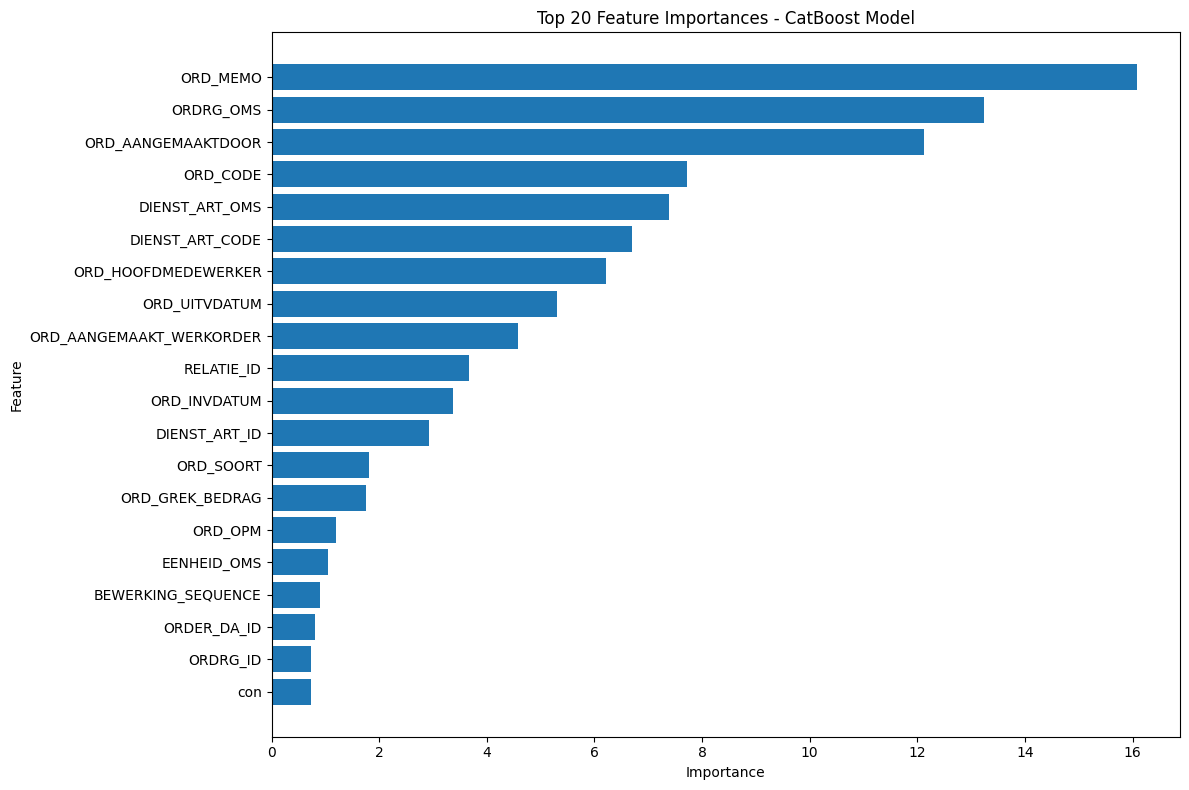

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the CatBoost model
feature_importance = model.get_feature_importance()
feature_names = valid_columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Display top 20 features
print("Top 20 Most Important Features:")
print(importance_df.head(20))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(min(20, len(importance_df))), importance_df['importance'].head(20))
plt.yticks(range(min(20, len(importance_df))), importance_df['feature'].head(20))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances - CatBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
df_zonder_eenheid_uur = df[df['EENHEID_OMS'] != 'uur']

In [ ]:
df_zonder_eenheid_uur['EENHEID_OMS'].value_counts()

EENHEID_OMS
ton     2015
ha.     1748
keer    1543
m3.      748
stuk     565
pak      530
m3       141
ltr.      78
dag       18
kg         6
week       2
Hdag       1
st         1
m2         1
Name: count, dtype: int64

In [ ]:
# Get EENHEID_OMS values that appear less than 5 times
rare_eenheden = df['EENHEID_OMS'].value_counts()
rare_eenheden = rare_eenheden[rare_eenheden > 5].index

# Filter df to only include those rare values
df_zonder_eenheid_uur = df_zonder_eenheid_uur[df_zonder_eenheid_uur['EENHEID_OMS'].isin(rare_eenheden)]

In [ ]:
df_zonder_eenheid_uur.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS,ORDRG_ID,ORDRG_HOEVEELHEID,EENHEID_ID,ORDRG_OMS,EENHEID_OMS,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,VHO_TYPE
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.0,670.0,None,None,23_hulter,0.0,0.75,30291.0,16164.0,221.0,4004,CONTAINER AAN- EN AFVOER,30966.0,0.00,651.0,Container aan- en afvoer,keer,NaN,NaN,10028.0,330.0,12009.0,None,15059.0,NaN,358,2023-02-09,2023-02-09,,None,None,None,None,None,None,,13:15:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,0.00,NaN,NaN,Gerjan,None,-1.0,14:00:00,1.0,2023-02-09,0.0,None,None,2023-03-09 09:44:20,1003.0,,0.000000,0.0,0.0,None,None,NaN,None,None,117.0,0.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.0,659.0,None,None,23_hulter,0.0,2.50,30273.0,16151.0,221.0,4004,CONTAINER AAN- EN AFVOER,30948.0,2.00,651.0,Container aan- en afvoer,keer,NaN,NaN,11555.0,330.0,11710.0,None,15068.0,NaN,348,2023-02-08,2023-02-08,,None,None,None,None,None,None,,13:30:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,329.80,NaN,NaN,Gerjan,None,-1.0,16:00:00,1.0,2023-02-08,0.0,None,None,2023-03-15 11:23:47,1003.0,,399.058014,0.0,0.0,None,None,NaN,None,None,117.0,0.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN
6,2532,2023-02-13,NaN,10044.0,3,2.50,None,1003,16191.0,30327.0,2047.0,02:30,31002.0,None,None,7,2023,07:30,10:00,0.0,None,NaN,None,,0.0,719.0,None,None,23_hulter,0.0,2.50,30327.0,16191.0,251.0,0251,"MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM...",31002.0,32.58,650.0,Mest afgevoerd Huiskes/Wijster,ton,NaN,NaN,10044.0,330.0,11674.0,None,15237.0,NaN,385,2023-02-10,2023-02-13,,None,None,None,None,None,None,,07:00:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,472.41,NaN,NaN,Arjan,None,-1.0,10:00:00,1.0,2023-02-13,0.0,None,None,2023-02-20 15:20:56,1003.0,Tonnen invullen en bij notities het vdmnr note...,571.616089,0.0,0.0,None,None,NaN,None,None,105.0,0.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,NaN
12,2534,2023-02-13,NaN,10005.0,3,2.00,None,1003,16287.0,30513.0,2180.0,02:00,31225.0,None,None,7,2023,19:00,21:00,0.0,None,NaN,None,,0.0,740.0,None,None,23_hulter,0.0,2.00,30513.0,16287.0,10030.0,4020,TRANSPORT ERWTENSCHALEN,31225.0,10.50,650.0,Transport erbsenbesatz,ton,NaN,NaN,10005.0,330.0,11505.0,None,15241.0,NaN,476,2023-02-13,2023-02-13,,None,None,None,None,None,None,,19:00:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,472.50,NaN,NaN,Gerjan,None,-1.0,21:00:00,1.0,2023-02-13,0.0,None,None

In [ ]:
df_zonder_eenheid_uur['arbeid_per_uur'] = df_zonder_eenheid_uur['URENVERANTW_AANTAL_GECORRIGEERD'] / df_zonder_eenheid_uur['ORDRG_HOEVEELHEID']

In [ ]:
df_zonder_eenheid_uur.head()

,URENVERANTW_ID,URENVERANTW_DATUM,URENVERANTW_PROJID,URENVERANTW_RELATIEID,URENVERANTW_TIJDSOORT,URENVERANTW_AANTAL,URENVERANTW_MACHID,URENVERANTW_MEDID,URENVERANTW_ORDERID,URENVERANTW_ORDDAID,URENVERANTW_ORDMEDID,URENVERANTW_TIJD,URENVERANTW_ORDRG_ID,URENVERANTW_GROEPSID,URENVERANTW_CONTROLE,URENVERANTW_WEEKNR,URENVERANTW_JAAR,URENVERANTW_STARTTIJD,URENVERANTW_STOPTIJD,URENVERANTW_ONDERBREKING,URENVERANTW_OPMERKING,URENVERANTW_KLEUR,URENVERANTW_PLAN_ID,URENVERANTW_NOTITIE,URENVERANTW_ONDERBR_AANTAL,URENVERANTW_WO_URENID,URENVERANTW_REISTIJD,URENVERANTW_KM,con,aftrek_tijd,URENVERANTW_AANTAL_GECORRIGEERD,ORDER_DA_ID,ORD_ID,DIENST_ART_ID,DIENST_ART_CODE,DIENST_ART_OMS,ORDRG_ID,ORDRG_HOEVEELHEID,EENHEID_ID,ORDRG_OMS,EENHEID_OMS,PROJ_ID,LOC_ID,RELATIE_ID,OS_ID,FACT_ID,ADM_ID,ADRES_ID,TB__ADRES_ID,ORD_CODE,ORD_INVDATUM,ORD_UITVDATUM,ORD_OPM,ORD_OMS,ORD_GEREEDDATUM,PARENT_ORDID,ORD_BTWCODE,ORD_EENHEIDCODE,ORD_AFDELING_ID,ORD_DOCUMENT,ORD_TIJD,ORD_DEFINITIEF,ORD_SOORT,ORD_GREK_OBV,ORD_GREK_LOONSOM,ORD_GREK_PERC,ORD_GREK_BEDRAG,ORD_AGLOREKNR,ORD_AGLOCODE,ORD_FACTUUR_TOTAAL,ORD_NAARVOLGENDJAAR,ORD_CONTACTMEDEWERKER_ID,ORD_AANGEMAAKTDOOR,ORD_MACHINE_ID,ORD_ADM_ID,ORD_EINDTIJD,ORD_COMPLEET,ORD_EINDDATUM,ORD_OPENWERK,DATUMEXPORTNAARSUBADM,DATUMIMPORTINSUBADM,ORD_MUTDATUM,ORD_HOOFDMEDEWERKER,ORD_MEMO,ORD_FACT_TOTAAL_INC,ORD_MEMOBEWAREN,ORD_MAILUREN_VERSTUURD,ORD_DAGSTAAT,ORD_GECONTROLEERD,ORD_MORESTATUS,ORD_MEMOAPP,ORD_AANTALLENMEMOAPP,BEWERKING_ID,BEWERKING_SEQUENCE,PROJECT_SEQUENCE,ORD_CREDIT,ORD_AANGEMAAKT_WERKORDER,WO_NR,WO_ID,ORD_SOURCE_ID,ORD_EXTERN_ID,VHO_ID,VHO_TYPE,arbeid_per_uur
2,2340,2023-02-09,NaN,10028.0,3,0.75,None,1003,16164.0,30291.0,2016.0,00:45,30966.0,None,None,6,2023,13:15,14:00,0.0,None,NaN,None,,0.0,670.0,None,None,23_hulter,0.0,0.75,30291.0,16164.0,221.0,4004,CONTAINER AAN- EN AFVOER,30966.0,0.00,651.0,Container aan- en afvoer,keer,NaN,NaN,10028.0,330.0,12009.0,None,15059.0,NaN,358,2023-02-09,2023-02-09,,None,None,None,None,None,None,,13:15:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,0.00,NaN,NaN,Gerjan,None,-1.0,14:00:00,1.0,2023-02-09,0.0,None,None,2023-03-09 09:44:20,1003.0,,0.000000,0.0,0.0,None,None,NaN,None,None,117.0,0.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN,inf
4,2307,2023-02-08,NaN,11555.0,3,2.50,None,1003,16151.0,30273.0,2008.0,02:30,30948.0,None,None,6,2023,13:30,16:00,0.0,None,NaN,None,,0.0,659.0,None,None,23_hulter,0.0,2.50,30273.0,16151.0,221.0,4004,CONTAINER AAN- EN AFVOER,30948.0,2.00,651.0,Container aan- en afvoer,keer,NaN,NaN,11555.0,330.0,11710.0,None,15068.0,NaN,348,2023-02-08,2023-02-08,,None,None,None,None,None,None,,13:30:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,329.80,NaN,NaN,Gerjan,None,-1.0,16:00:00,1.0,2023-02-08,0.0,None,None,2023-03-15 11:23:47,1003.0,,399.058014,0.0,0.0,None,None,NaN,None,None,117.0,0.0,0.0,NaN,1.0,NaN,NaN,Werkorder,None,None,NaN,1.250000
6,2532,2023-02-13,NaN,10044.0,3,2.50,None,1003,16191.0,30327.0,2047.0,02:30,31002.0,None,None,7,2023,07:30,10:00,0.0,None,NaN,None,,0.0,719.0,None,None,23_hulter,0.0,2.50,30327.0,16191.0,251.0,0251,"MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM...",31002.0,32.58,650.0,Mest afgevoerd Huiskes/Wijster,ton,NaN,NaN,10044.0,330.0,11674.0,None,15237.0,NaN,385,2023-02-10,2023-02-13,,None,None,None,None,None,None,,07:00:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,472.41,NaN,NaN,Arjan,None,-1.0,10:00:00,1.0,2023-02-13,0.0,None,None,2023-02-20 15:20:56,1003.0,Tonnen invullen en bij notities het vdmnr note...,571.616089,0.0,0.0,None,None,NaN,None,None,105.0,0.0,0.0,NaN,0.0,NaN,NaN,Werkexpert,None,None,NaN,0.076734
12,2534,2023-02-13,NaN,10005.0,3,2.00,None,1003,16287.0,30513.0,2180.0,02:00,31225.0,None,None,7,2023,19:00,21:00,0.0,None,NaN,None,,0.0,740.0,None,None,23_hulter,0.0,2.00,30513.0,16287.0,10030.0,4020,TRANSPORT ERWTENSCHALEN,31225.0,10.50,650.0,Transport erbsenbesatz,ton,NaN,NaN,10005.0,330.0,11505.0,None,15241.0,NaN,476,2023-02-13,2023-02-13,,None,None,None,None,None,None,,19:00:00,1.0,1.0,0.0,0.0,0.0,0.0,None,None,472.50,NaN,NaN,Gerjan,None,-1.0,

In [ ]:
df_zonder_eenheid_uur = df_zonder_eenheid_uur[['arbeid_per_uur', 'DIENST_ART_OMS']]

In [ ]:
df_zonder_eenheid_uur.head()

,arbeid_per_uur,DIENST_ART_OMS
2,inf,CONTAINER AAN- EN AFVOER
4,1.250000,CONTAINER AAN- EN AFVOER
6,0.076734,"MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM..."
12,0.190476,TRANSPORT ERWTENSCHALEN
15,0.134120,VULZAND EXCL. TR.


In [ ]:
df_zonder_eenheid_uur = df_zonder_eenheid_uur.dropna()

In [ ]:
df_zonder_eenheid_uur.head()

,arbeid_per_uur,DIENST_ART_OMS
2,inf,CONTAINER AAN- EN AFVOER
4,1.250000,CONTAINER AAN- EN AFVOER
6,0.076734,"MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM..."
12,0.190476,TRANSPORT ERWTENSCHALEN
15,0.134120,VULZAND EXCL. TR.


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:

embedder = SentenceTransformer("all-MiniLM-L6-v2")

X = embedder.encode(df_zonder_eenheid_uur["DIENST_ART_OMS"].tolist())
y = df_zonder_eenheid_uur["arbeid_per_uur"] 


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
y.isna().sum(), np.isinf(y).sum()

(np.int64(0), np.int64(1549))

In [ ]:
# Filter out infinite and NaN values
valid_mask = ~(y.isna() | np.isinf(y))
X_clean = X[valid_mask]
y_clean = y[valid_mask]
print(f"Removed {(~valid_mask).sum()} rows with NaN/inf values")
print(f"Remaining samples: {len(y_clean)}")

Removed 1549 rows with NaN/inf values
Remaining samples: 5514


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [ ]:
print(X_train)

[[-0.07288293  0.02796173 -0.00348624 ... -0.04800335  0.06408021
  -0.02269485]
 [-0.06827898  0.06780826 -0.02556639 ...  0.04707677 -0.01376323
   0.02318694]
 [ 0.01781136  0.01652474 -0.01260889 ...  0.10528721  0.00829959
   0.02692428]
 ...
 [-0.05764975  0.08014119 -0.06370308 ...  0.00018151  0.06946635
  -0.0435363 ]
 [-0.03501029  0.09162318  0.01779051 ...  0.01190767  0.03762265
  -0.0203926 ]
 [ 0.00442214  0.05891662 -0.01483716 ...  0.06931785 -0.01171109
  -0.00852739]]


In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    tree_method="hist"
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score


y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


MAE: 5.061856695747277
R2: -0.0009928299175050448


In [ ]:
# Trek een paar voorbeelden uit de test set
import pandas as pd

# Haal de indices van de test set terug
test_indices = y_test.index[:5]  # Eerste 5 voorbeelden

# Maak predictions voor deze voorbeelden
sample_predictions = model.predict(X_test[:5])

# Haal de originele data op (zonder EENHEID_OMS)
comparison_df = pd.DataFrame({
    'DIENST_ART_OMS': df_zonder_eenheid_uur.loc[test_indices, 'DIENST_ART_OMS'].values,
    'Werkelijk': y_test.iloc[:5].values,
    'Voorspelling': sample_predictions,
    'Verschil': y_test.iloc[:5].values - sample_predictions
})

comparison_df

,DIENST_ART_OMS,Werkelijk,Voorspelling,Verschil
0,AFVOER PAARDENMEST,3.000000,1.805179,1.194821
1,CONTAINER AAN- EN AFVOER,1.250000,1.530072,-0.280072
2,GROOTPAK FOLIE,0.013333,0.071941,-0.058608
3,"MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM...",0.059587,0.092188,-0.032601
4,TRANSPORT ERWTENSCHALEN,0.156642,0.170318,-0.013676


In [ ]:
# Hoeveel waardes in test set zijn werkelijk 1?
(y_test == 1.0).sum(), len(y_test), (y_test == 1.0).sum() / len(y_test) * 100

(np.int64(32), 1103, np.float64(2.901178603807797))

In [ ]:
df_model_medew = df.copy()

# Filter: alleen rows met DIENST_ART_OMS en URENVERANTW_MEDID
df_model_medew = df_model_medew[df_model_medew['DIENST_ART_OMS'].notna() & 
                                 df_model_medew['URENVERANTW_MEDID'].notna()].copy()
# Filter werknemers met minimaal 30 entries
medew_counts = df_model_medew['URENVERANTW_MEDID'].value_counts()
medew_met_genoeg_data = medew_counts[medew_counts >= 30].index
df_model_medew = df_model_medew[df_model_medew['URENVERANTW_MEDID'].isin(medew_met_genoeg_data)]

df_model_medew[['URENVERANTW_MEDID', 'DIENST_ART_OMS', 'URENVERANTW_AANTAL_GECORRIGEERD']].head(10)

,URENVERANTW_MEDID,DIENST_ART_OMS,URENVERANTW_AANTAL_GECORRIGEERD
0,1031,DRAINAGE SCHOONSPUITEN,8.50
1,1031,MESTSTROOIER,4.50
2,1003,CONTAINER AAN- EN AFVOER,0.75
3,1006,WERKPLAATS MONTEUR,9.50
4,1003,CONTAINER AAN- EN AFVOER,2.50
5,1011,MOBIELE KRAAN,8.00
6,1003,"MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM...",2.50
7,1084,MESTTRANSPORT VRACHTAUTO,2.00
8,1006,WERKPLAATS MONTEUR,8.50
9,1038,MANUREN,6.00


In [ ]:
# Maak features: dienst embedding + medewerker ID
# Dienst → text embedding (zoals eerder)
X_dienst = embedder.encode(df_model_medew['DIENST_ART_OMS'].tolist())

# Medewerker → numerical feature (ID)
X_medew = df_model_medew['URENVERANTW_MEDID'].values.reshape(-1, 1)

# Combineer beide features
import numpy as np
X_combined = np.hstack([X_dienst, X_medew])

# Target: gecorrigeerde uren
y_medew = df_model_medew['URENVERANTW_AANTAL_GECORRIGEERD']

print(f"Feature shape: {X_combined.shape}")
print(f"  - Dienst embeddings: {X_dienst.shape[1]} dimensies")
print(f"  - Medewerker ID: 1 dimensie")
print(f"Target shape: {y_medew.shape}")

Feature shape: (40960, 385)
  - Dienst embeddings: 384 dimensies
  - Medewerker ID: 1 dimensie
Target shape: (40960,)


In [ ]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train_medew, X_test_medew, y_train_medew, y_test_medew = train_test_split(
    X_combined, y_medew, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train_medew)}")
print(f"Test samples: {len(X_test_medew)}")

Training samples: 32768
Test samples: 8192


In [ ]:
# Train XGBoost model
import xgboost as xgb

model_medew = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    tree_method="hist"
)

model_medew.fit(X_train_medew, y_train_medew)
print("Model getraind!")

Model getraind!


In [ ]:
# Evalueer model
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_medew = model_medew.predict(X_test_medew)

mae = mean_absolute_error(y_test_medew, y_pred_medew)
r2 = r2_score(y_test_medew, y_pred_medew)

print(f"Model Performance:")
print(f"  MAE: {mae:.2f} uur")
print(f"  R²: {r2:.3f}")
print(f"\nDit betekent: gemiddeld {mae:.2f} uur verschil tussen voorspelling en werkelijkheid")

Model Performance:
  MAE: 1.95 uur
  R²: 0.420

Dit betekent: gemiddeld 1.95 uur verschil tussen voorspelling en werkelijkheid


In [ ]:
# Voorbeeldvoorspelling: geef dienst + medewerker, krijg voorspelde uren
def voorspel_werktijd(dienst_naam, medewerker_id):
    """
    Voorspel hoelang een specifieke medewerker over een dienst doet.
    
    Args:
        dienst_naam (str): Naam van de dienst (bijv. "Manuren")
        medewerker_id (int): ID van de medewerker
    
    Returns:
        float: Voorspelde aantal uren
    """
    # Maak embedding van dienst
    dienst_embedding = embedder.encode([dienst_naam])
    
    # Combineer met medewerker ID
    medew_feature = np.array([[medewerker_id]])
    features = np.hstack([dienst_embedding, medew_feature])
    
    # Voorspel
    voorspelling = model_medew.predict(features)[0]
    
    return voorspelling

# Test met een paar voorbeelden uit de test set
test_indices = y_test_medew.index[:5]
test_samples = df_model_medew.loc[test_indices]

print("Voorbeeldvoorspellingen:\n")
for idx in test_indices:
    row = df_model_medew.loc[idx]
    dienst = row['DIENST_ART_OMS']
    medew = row['URENVERANTW_MEDID']
    werkelijk = row['URENVERANTW_AANTAL_GECORRIGEERD']
    
    voorspeld = voorspel_werktijd(dienst, medew)
    
    print(f"Medewerker {medew} - {dienst}")
    print(f"  Werkelijk: {werkelijk:.2f} uur")
    print(f"  Voorspeld: {voorspeld:.2f} uur")
    print(f"  Verschil: {abs(werkelijk - voorspeld):.2f} uur\n")

Voorbeeldvoorspellingen:

Medewerker 1084 - MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM.KOSTEN)
  Werkelijk: 2.25 uur
  Voorspeld: 2.86 uur
  Verschil: 0.61 uur

Medewerker 381 - Kippertrailer gestuurd
  Werkelijk: 2.25 uur
  Voorspeld: 5.52 uur
  Verschil: 3.27 uur

Medewerker 28 - Mobiele kraan 15-17 ton 
  Werkelijk: 1.00 uur
  Voorspeld: 6.10 uur
  Verschil: 5.10 uur

Medewerker 1084 - MESTTRANSPORT VRACHTAUTO
  Werkelijk: 11.50 uur
  Voorspeld: 4.34 uur
  Verschil: 7.16 uur

Medewerker 51 - Manuren
  Werkelijk: 4.25 uur
  Voorspeld: 6.22 uur
  Verschil: 1.97 uur



In [ ]:
# Save the model with proper file extension
model_medew.save_model('eerstepoging.json')

In [ ]:
# Sla data op in simpel CSV formaat
df_export_simpel = pd.DataFrame({
    'medewerker_id': df_model_medew['URENVERANTW_MEDID'].values,
    'dienst_omschrijving': df_model_medew['DIENST_ART_OMS'].values,
    'target_uren': y_medew.values
})

df_export_simpel.to_csv('model_data_simpel.csv', index=False)
print(f"✅ Data opgeslagen: {len(df_export_simpel)} rijen, {len(df_export_simpel.columns)} kolommen")
print(df_export_simpel.head())

✅ Data opgeslagen: 40960 rijen, 3 kolommen
   medewerker_id       dienst_omschrijving  target_uren
0           1031    DRAINAGE SCHOONSPUITEN         8.50
1           1031              MESTSTROOIER         4.50
2           1003  CONTAINER AAN- EN AFVOER         0.75
3           1006        WERKPLAATS MONTEUR         9.50
4           1003  CONTAINER AAN- EN AFVOER         2.50


# Model: Voorspel werktijd per werknemer + dienst

## MLP Model met TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

print(f"TensorFlow versie: {tf.__version__}")

TensorFlow versie: 2.20.0


In [ ]:
# Schaal de features voor betere neural network performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_medew)
X_test_scaled = scaler.transform(X_test_medew)

print(f"Features geschaald:")
print(f"  Training set: {X_train_scaled.shape}")
print(f"  Test set: {X_test_scaled.shape}")

Features geschaald:
  Training set: (32768, 385)
  Test set: (8192, 385)


In [ ]:
# Bouw MLP model
model_mlp = keras.Sequential([
    # Input layer
    layers.Input(shape=(X_train_scaled.shape[1],)),
    
    # Hidden layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer (regressie)
    layers.Dense(1)
])

model_mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,873 (562.00 KB)

 Trainable params: 142,977 (558.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Compileer model
model_mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='huber',  # Robuust tegen outliers
    metrics=['mae', 'mse']
)

print("Model gecompileerd!")

Model gecompileerd!


In [ ]:
# Early stopping om overfitting te voorkomen
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1
)

# Train het model
history = model_mlp.fit(
    X_train_scaled, 
    y_train_medew,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✅ Model training voltooid!")

Epoch 1/150
820/820 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.0947 - mae: 2.5481 - mse: 10.8765 - val_loss: 1.6887 - val_mae: 2.1265 - val_mse: 8.3399 - learning_rate: 0.0010
Epoch 2/150
820/820 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 1.8608 - mae: 2.3069 - mse: 9.1074 - val_loss: 1.6567 - val_mae: 2.0990 - val_mse: 7.8836 - learning_rate: 0.0010
Epoch 3/150
820/820 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - loss: 1.7987 - mae: 2.2428 - mse: 8.7178 - val_loss: 1.6455 - val_mae: 2.0821 - val_mse: 7.9057 - learning_rate: 0.0010
Epoch 4/150
820/820 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - loss: 1.7741 - mae: 2.2164 - mse: 8.5595 - val_loss: 1.6512 - val_mae: 2.0914 - val_mse: 7.9887 - learning_rate: 0.0010
Epoch 5/150
820/820 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - loss: 1.7640 - mae: 2.2068 - mse: 8.4540 - val_loss: 1.6265 - val_mae: 2.0695 - val_mse: 7.5148 - learning_rate: 0.0010
Epoch 6/150
820/820 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 1.7398 - mae: 2.1809 - mse: 8.3571 - val_loss: 1.6304

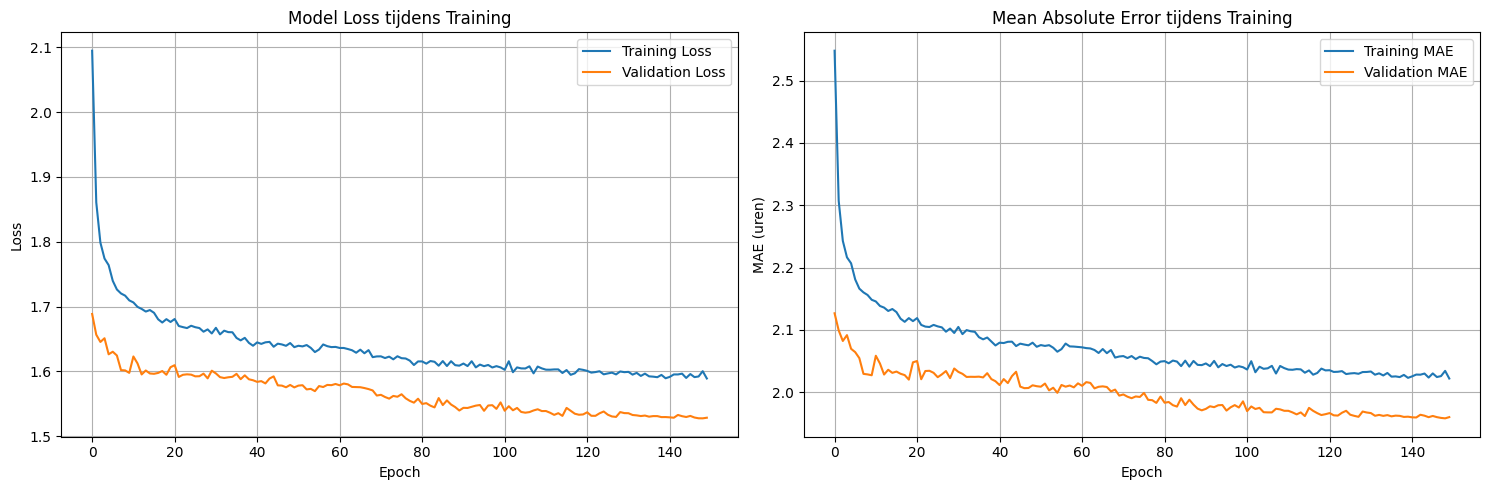

In [ ]:
# Plot training geschiedenis
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss tijdens Training')
ax1.legend()
ax1.grid(True)

# MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE (uren)')
ax2.set_title('Mean Absolute Error tijdens Training')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evalueer MLP model op test set
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

y_pred_mlp = model_mlp.predict(X_test_scaled).flatten()

mae_mlp = mean_absolute_error(y_test_medew, y_pred_mlp)
mse_mlp = mean_squared_error(y_test_medew, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test_medew, y_pred_mlp)

print("=" * 60)
print("MLP MODEL PERFORMANCE")
print("=" * 60)
print(f"MAE:   {mae_mlp:.2f} uur")
print(f"RMSE:  {rmse_mlp:.2f} uur")
print(f"R²:    {r2_mlp:.3f}")
print("=" * 60)
print(f"\nDit betekent: gemiddeld {mae_mlp:.2f} uur verschil tussen voorspelling en werkelijkheid")

# Vergelijk met XGBoost (als die is getraind)
try:
    print("\n" + "=" * 60)
    print("VERGELIJKING MET XGBOOST")
    print("=" * 60)
    print(f"XGBoost MAE: {mae:.2f} uur")
    print(f"MLP MAE:     {mae_mlp:.2f} uur")
    print(f"\nVerschil:    {abs(mae - mae_mlp):.2f} uur")
    if mae_mlp < mae:
        print(f"✅ MLP is {mae - mae_mlp:.2f} uur nauwkeuriger!")
    else:
        print(f"⚠️ XGBoost is {mae_mlp - mae:.2f} uur nauwkeuriger")
except:
    print("\n(XGBoost model niet gevonden voor vergelijking)")

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
MLP MODEL PERFORMANCE
MAE:   2.01 uur
RMSE:  2.73 uur
R²:    0.330

Dit betekent: gemiddeld 2.01 uur verschil tussen voorspelling en werkelijkheid

VERGELIJKING MET XGBOOST
XGBoost MAE: 1.95 uur
MLP MAE:     2.01 uur

Verschil:    0.06 uur
⚠️ XGBoost is 0.06 uur nauwkeuriger


In [ ]:
# Voorspelfunctie voor MLP model
def voorspel_werktijd_mlp(dienst_naam, medewerker_id):
    """
    Voorspel hoelang een specifieke medewerker over een dienst doet met MLP.
    
    Args:
        dienst_naam (str): Naam van de dienst (bijv. "Manuren")
        medewerker_id (int): ID van de medewerker
    
    Returns:
        float: Voorspelde aantal uren
    """
    # Maak embedding van dienst
    dienst_embedding = embedder.encode([dienst_naam])
    
    # Combineer met medewerker ID
    medew_feature = np.array([[medewerker_id]])
    features = np.hstack([dienst_embedding, medew_feature])
    
    # Schaal de features
    features_scaled = scaler.transform(features)
    
    # Voorspel
    voorspelling = model_mlp.predict(features_scaled, verbose=0)[0][0]
    
    return voorspelling

# Test met voorbeelden uit de test set
test_indices = y_test_medew.index[:5]
test_samples = df_model_medew.loc[test_indices]

print("VOORBEELDVOORSPELLINGEN MET MLP:\n")
print("=" * 70)
for idx in test_indices:
    row = df_model_medew.loc[idx]
    dienst = row['DIENST_ART_OMS']
    medew = row['URENVERANTW_MEDID']
    werkelijk = row['URENVERANTW_AANTAL_GECORRIGEERD']
    
    voorspeld = voorspel_werktijd_mlp(dienst, medew)
    
    print(f"\nMedewerker {medew} - {dienst[:50]}")
    print(f"  Werkelijk: {werkelijk:.2f} uur")
    print(f"  Voorspeld: {voorspeld:.2f} uur")
    print(f"  Verschil:  {abs(werkelijk - voorspeld):.2f} uur")
print("\n" + "=" * 70)

VOORBEELDVOORSPELLINGEN MET MLP:


Medewerker 1084 - MEST AFGEVOERD (INCL. WEGEN, ANALYSEREN EN ADM.KOS
  Werkelijk: 2.25 uur
  Voorspeld: 2.40 uur
  Verschil:  0.15 uur

Medewerker 381 - Kippertrailer gestuurd
  Werkelijk: 2.25 uur
  Voorspeld: 4.23 uur
  Verschil:  1.98 uur

Medewerker 28 - Mobiele kraan 15-17 ton 
  Werkelijk: 1.00 uur
  Voorspeld: 7.10 uur
  Verschil:  6.10 uur

Medewerker 1084 - MESTTRANSPORT VRACHTAUTO
  Werkelijk: 11.50 uur
  Voorspeld: 4.18 uur
  Verschil:  7.32 uur

Medewerker 51 - Manuren
  Werkelijk: 4.25 uur
  Voorspeld: 1.68 uur
  Verschil:  2.57 uur



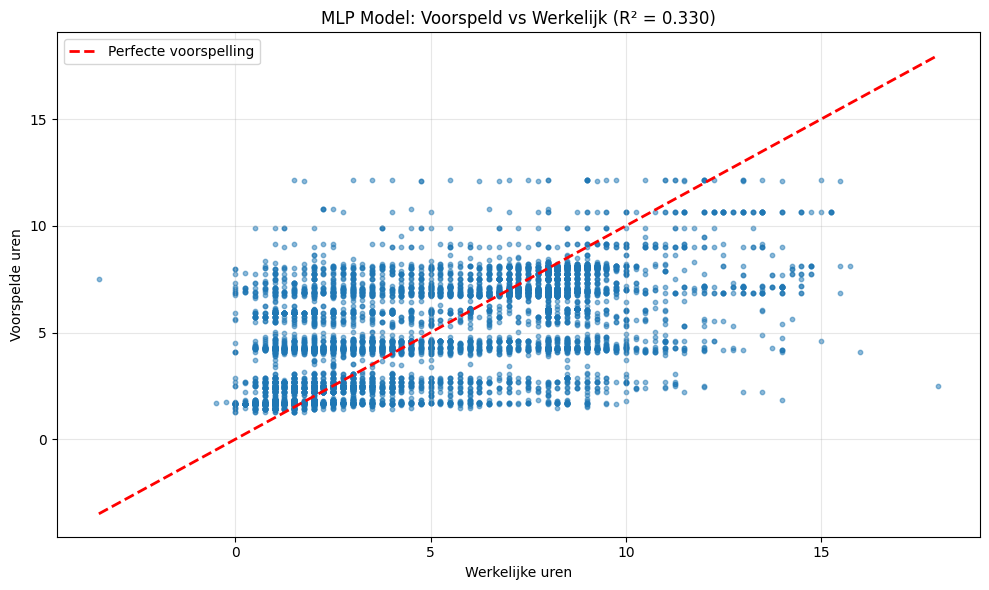

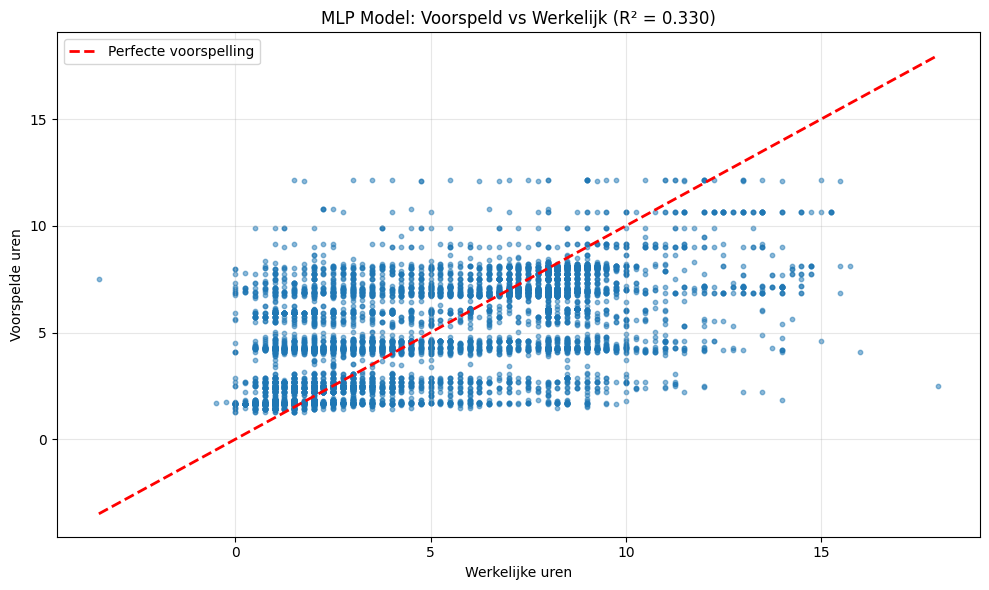

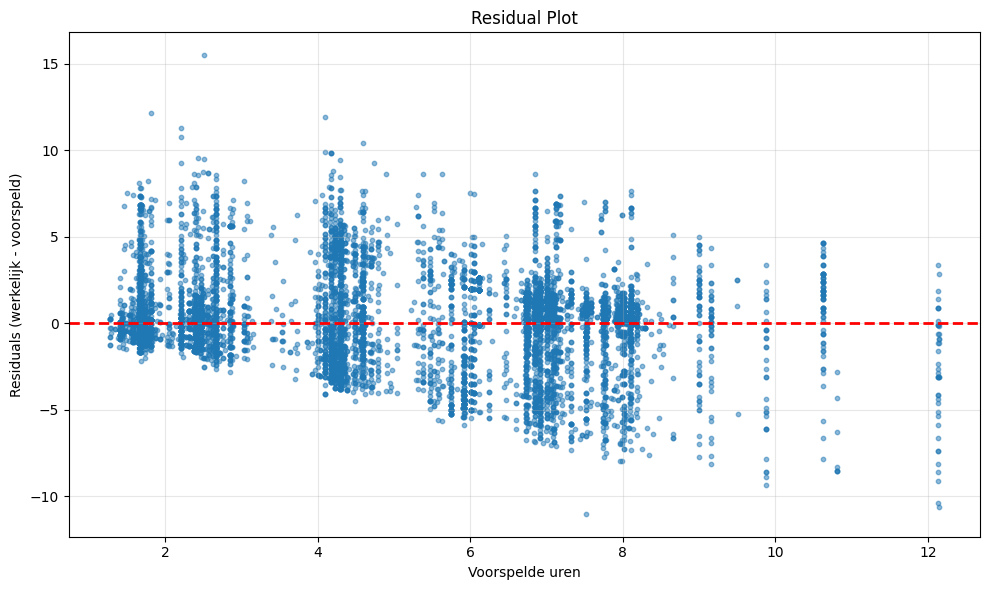

In [ ]:
# Visualiseer voorspellingen vs werkelijkheid
plt.figure(figsize=(10, 6))
plt.scatter(y_test_medew, y_pred_mlp, alpha=0.5, s=10)
plt.plot([y_test_medew.min(), y_test_medew.max()], 
         [y_test_medew.min(), y_test_medew.max()], 
         'r--', lw=2, label='Perfecte voorspelling')
plt.xlabel('Werkelijke uren')
plt.ylabel('Voorspelde uren')
plt.title(f'MLP Model: Voorspeld vs Werkelijk (R² = {r2_mlp:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test_medew - y_pred_mlp
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_mlp, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Voorspelde uren')
plt.ylabel('Residuals (werkelijk - voorspeld)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Sla het MLP model op
model_mlp.save('mlp_werktijd_model.keras')
print("✅ MLP model opgeslagen als 'mlp_werktijd_model.keras'")

# Sla ook de scaler op voor later gebruik
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler opgeslagen als 'scaler.pkl'")

✅ MLP model opgeslagen als 'mlp_werktijd_model.keras'
✅ Scaler opgeslagen als 'scaler.pkl'
